# <center>${\textbf{Artificial Intelligence Decision Support System}}$<br>${\textbf{ for Groundwater Management under Climate Change:}}$</center><br><center>${\textbf{ Application to Mornag Region in Tunisia}}$</center><br><center>${\textbf{Part 3 : Data Modeling  and Evaluation}}$</center>


**Table of Contents**

* [Importing Libraries](#libraris)
* [Data Modelisation](#models)
    * [LSTM:Long Short Term Memory](#lstm)
    * [LightGBM: Light Gradient Boosting Machine](#lgbm) 
    * [XGBoost :eXtreme Gradient Boosting](#xgb)    

<a id="libraries"></a>

${\textbf{Importing Libraries}}$

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime 
import time

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  GridSearchCV

import xgboost as xgb
from xgboost import plot_importance

In [2]:
Historical_Data = pd.read_pickle('./Pickles/Data/Historical_Data.pkl')

<a id="models"></a>

## ${\textbf{ Data Modelisation}}$

<a id="lstm"></a>

>${\textbf{LSTM:Long Short Term Memory}}$

In [3]:
df=Historical_Data.copy()
list_Year= [d.year for d in df.Time_RF]
list_Month= [d.month for d in df.Time_RF]
df['Month'] = list_Month
df['Year'] = list_Year

df.index=df.Time_RF
del df['Time_RF']
del df['Time_PZ']
del df['Lat']
del df['RF']
del df['Lon']
del df['Lat_Pluviometer']
del df['Lon_Pluviometer']
# df[[col for col in df.columns if df[col].dtypes == object]] = df[[col for col in df.columns if df[col].dtypes == object]].astype('category')
lb_make = LabelEncoder()
df["Piezometer"] = lb_make.fit_transform(df["Piezometer"])
lb_make1 = LabelEncoder()
df["Pluviometer"] = lb_make1.fit_transform(df["Pluviometer"])
lb_make2 = LabelEncoder()
df["SPI_classes"] = lb_make2.fit_transform(df["SPI_classes"])

In [4]:
column=['Pz','Piezometer', 'Pluviometer', 'YearlyRF', 'SemestrialRF',
       'TrimestrialRF', 'MonthlyRF', 'Zone', 'SPI', 'SPI_classes', 'Month',
       'Year']#Reindexing
df=df.reindex(column, axis='columns')
df

Pz  Piezometer  Pluviometer  YearlyRF  SemestrialRF  \
Time_RF                                                                  
2005-01-09  53.433000          30            7     204.2         204.2   
2005-02-09  53.433000          30            7     204.2         204.2   
2005-03-09  53.433000          30            7     204.2         204.2   
2005-04-09  53.433000          30            7     204.2         204.2   
2005-05-09  53.433000          30            7     204.2         204.2   
...               ...         ...          ...       ...           ...   
2015-08-27  44.770923          40           12     294.3          38.5   
2015-08-28  44.770923          40           12     294.3          38.5   
2015-08-29  44.770923          40           12     294.3          38.5   
2015-08-30  44.770923          40           12     294.3          38.5   
2015-08-31  44.770923          40           12     294.3          38.5   

            TrimestrialRF  MonthlyRF  Zone       SPI  SPI_classes  Month  Year  
Time_RF                                                                         
2005-01-09           28.1       28.1     1 -0.236898            2      1  2005  
2005-02-09           28.1       28.1     1 -0.236898            2      2  2005  
2005-03-09           28.1       28.1     1 -0.236898            2      3  2005  
2005-04-09           28.1       28.1     1 -0.236898            2      4  2005  
2005-05-09           28.1       28.1     1 -0.236898            2      5  2005  
...                   ...        ...   ...       ...          ...    ...   ...  
2015-08-27           38.5       38.5     2 -0.236898            2      8  2015  
2015-08-28           38.5       38.5     2 -0.236898            2      8  2015  
2015-08-29           38.5       38.5     2 -0.236898            2      8  2015  
2015-08-30           38.5       38.5     2 -0.236898            2      8  2015  
2015-08-31           38.5       38.5     2 -0.236898            2      8  2015  

[285480 rows x 12 columns]

In [5]:
df.columns

Index(['Pz', 'Piezometer', 'Pluviometer', 'YearlyRF', 'SemestrialRF',
       'TrimestrialRF', 'MonthlyRF', 'Zone', 'SPI', 'SPI_classes', 'Month',
       'Year'],
      dtype='object')

In [6]:
df.shape

(285480, 12)

In [7]:
test_split=round(len(df)*0.20)
test_split

57096

In [8]:
df_for_training=df[:-57096]
df_for_testing=df[-57096:]
print(df_for_training.shape)
print(df_for_testing.shape)

(228384, 12)
(57096, 12)


In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.99796646, 0.69767442, 0.41176471, ..., 0.66666667, 0.        ,
        0.        ],
       [0.99796646, 0.69767442, 0.41176471, ..., 0.66666667, 0.09090909,
        0.        ],
       [0.99796646, 0.69767442, 0.41176471, ..., 0.66666667, 0.18181818,
        0.        ],
       ...,
       [0.37742433, 0.09302326, 0.29411765, ..., 0.66666667, 0.45454545,
        1.        ],
       [0.37742433, 0.09302326, 0.29411765, ..., 0.66666667, 0.45454545,
        1.        ],
       [0.37742433, 0.09302326, 0.29411765, ..., 0.66666667, 0.45454545,
        1.        ]])

In [10]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training_scaled,30)
testX,testY=createXY(df_for_testing_scaled,30)

In [11]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (228354, 30, 12)
trainY Shape--  (228354,)


In [12]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (57066, 30, 12)
testY Shape--  (57066,)


In [13]:
print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

trainX[0]-- 
 [[0.99796646 0.69767442 0.41176471 0.12776776 0.37933083 0.12755334
  0.13438546 0.         0.         0.66666667 0.         0.        ]
 [0.99796646 0.69767442 0.41176471 0.12776776 0.37933083 0.12755334
  0.13438546 0.         0.         0.66666667 0.09090909 0.        ]
 [0.99796646 0.69767442 0.41176471 0.12776776 0.37933083 0.12755334
  0.13438546 0.         0.         0.66666667 0.18181818 0.        ]
 [0.99796646 0.69767442 0.41176471 0.12776776 0.37933083 0.12755334
  0.13438546 0.         0.         0.66666667 0.27272727 0.        ]
 [0.99796646 0.69767442 0.41176471 0.12776776 0.37933083 0.12755334
  0.13438546 0.         0.         0.66666667 0.36363636 0.        ]
 [0.99796646 0.69767442 0.41176471 0.12776776 0.37933083 0.12755334
  0.13438546 0.         0.         0.66666667 0.45454545 0.        ]
 [0.99796646 0.69767442 0.41176471 0.12776776 0.37933083 0.12755334
  0.13438546 0.         0.         0.66666667 0.54545455 0.        ]
 [0.99796646 0.69767442 0.4

In [14]:
trainX.shape[1],trainX.shape[2]

(30, 12)

In [19]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,12)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
  
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))

parameters = {'batch_size' : [10,20],
              'epochs' : [5,8],
              'optimizer':['adam']
             }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

In [20]:
grid_search = grid_search.fit(trainX,trainY)

Epoch 1/5
11418/11418 [==============================] - 158s 13ms/step - loss: 6.4558e-04 - val_loss: 1.1614e-04
Epoch 2/5
11418/11418 [==============================] - 133s 12ms/step - loss: 2.6981e-04 - val_loss: 1.7970e-04
Epoch 3/5
11418/11418 [==============================] - 133s 12ms/step - loss: 2.5172e-04 - val_loss: 4.5086e-04
Epoch 4/5
11418/11418 [==============================] - 135s 12ms/step - loss: 2.4703e-04 - val_loss: 3.8217e-04
Epoch 5/5
11418/11418 [==============================] - 58s 5ms/step - loss: 3.4555e-04
Epoch 1/5
11418/11418 [==============================] - 145s 12ms/step - loss: 0.0010 - val_loss: 2.5029e-04
Epoch 2/5
11418/11418 [==============================] - 142s 12ms/step - loss: 4.1169e-04 - val_loss: 9.8626e-05
Epoch 3/5
11418/11418 [==============================] - 142s 12ms/step - loss: 3.8996e-04 - val_loss: 2.5391e-04
Epoch 4/5
11418/11418 [==============================] - 145s 13ms/step - loss: 3.7427e-04 - val_loss: 1.9556e-04
Epo

In [21]:
grid_search.best_params_

{'batch_size': 10, 'epochs': 8, 'optimizer': 'adam'}

In [22]:
my_model=grid_search.best_estimator_.model

In [29]:
prediction=my_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

1784/1784 [==============================] - 7s 4ms/step
prediction
 [[0.37659425]
 [0.37659425]
 [0.3771896 ]
 ...
 [0.8632059 ]
 [0.8631403 ]
 [0.86307263]]

Prediction Shape- (57066, 1)


In [30]:
prediction_copies_array = np.repeat(prediction,12, axis=-1)

In [31]:
prediction_copies_array.shape

(57066, 12)

In [32]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),12)))[:,0]

In [33]:
original_copies_array = np.repeat(testY,12, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),12)))[:,0]

In [34]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [10.65444  10.65444  10.695427 ... 44.15537  44.15085  44.146194]

Original Values--  [10.71158654 10.71158654 10.71158654 ... 44.77092308 44.77092308
 44.77092308]


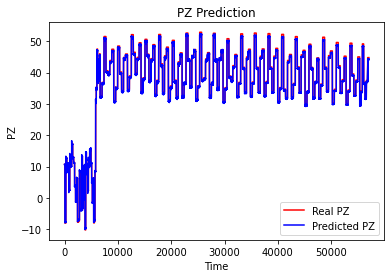

In [35]:
plt.plot(original, color = 'red', label = 'Real PZ')
plt.plot(pred, color = 'blue', label = 'Predicted PZ')
plt.title('PZ Prediction')
plt.xlabel('Time')
plt.ylabel('PZ')
plt.legend()
plt.show()

In [36]:
np.sqrt(mean_squared_error(pred,original))

0.7841446322114837

In [37]:
my_model.save('./Pickles/Models/my_modelLSTM.h5')
# Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('my_modelLSTM.h5')

# # Show the model architecture
# new_model.summary()

<a id="xgb"></a>

>${\textbf{XGBoost :eXtreme Gradient Boosting}}$

In [3]:
df=Historical_Data.copy()
list_Year= [d.year for d in df.Time_RF]
list_Month= [d.month for d in df.Time_RF]
df['Month'] = list_Month
df['Year'] = list_Year

df.index=df.Time_RF
del df['Time_RF']
del df['Time_PZ']
del df['RF']

# df[[col for col in df.columns if df[col].dtypes == object]] = df[[col for col in df.columns if df[col].dtypes == object]].astype('category')
lb_make = LabelEncoder()
df["Piezometer"] = lb_make.fit_transform(df["Piezometer"])
lb_make1 = LabelEncoder()
df["Pluviometer"] = lb_make1.fit_transform(df["Pluviometer"])
lb_make2 = LabelEncoder()
df["SPI_classes"] = lb_make2.fit_transform(df["SPI_classes"])

In [4]:
X = df.drop(['Pz'], axis=1)
y = df[['Pz']]
dev_X, val_X, dev_y, val_y = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [5]:
def run_xgb(train_X, train_y, val_X, val_y):
    params = {'objective': 'reg:squarederror', 
          'eval_metric': 'rmse',
        "booster" :"gbtree",
        'tree_method': 'gpu_hist',
          "min_child_weight":4,
          'eta': 0.01,
          'max_depth': 10, 
          'subsample': 0.7, 
          'colsample_bytree': 0.8,
          'alpha':0.001,
          'random_state': 42
             }
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 1000, watchlist, maximize=False, early_stopping_rounds = 100, verbose_eval=100)
    
    dtest = xgb.DMatrix(val_X)
    xgb_pred_y = model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit)
    
    return xgb_pred_y, model_xgb

In [6]:
# Training XGB
start_time = time.time()

pred_test_xgb, model_xgb = run_xgb(dev_X, dev_y, val_X, val_y)
print("XGB Training Completed...")

dt_time = (time.time() - start_time)



[0]	train-rmse:22.27547	valid-rmse:22.41244
[100]	train-rmse:8.22075	valid-rmse:8.26916
[200]	train-rmse:3.09382	valid-rmse:3.11056
[300]	train-rmse:1.24031	valid-rmse:1.24529
[400]	train-rmse:0.59436	valid-rmse:0.59606
[500]	train-rmse:0.36801	valid-rmse:0.36945
[600]	train-rmse:0.27940	valid-rmse:0.28150
[700]	train-rmse:0.21762	valid-rmse:0.22030
[800]	train-rmse:0.17299	valid-rmse:0.17624
[900]	train-rmse:0.14668	valid-rmse:0.15071
[999]	train-rmse:0.13033	valid-rmse:0.13474
XGB Training Completed...


In [7]:
import pickle
pickle.dump(model_xgb, open('./Pickles/Models/XGBmodel.pkl','wb'))

# # Loading model to compare the results
# XGBmodel = pickle.load(open('XGBmodel.pkl','rb'))

In [8]:
TestXGB=val_X.copy()
TestXGB["Piezometer"] = lb_make.inverse_transform(TestXGB["Piezometer"])

In [9]:
TestXGB["Actual"]=val_y
TestXGB["Predicted"]=pred_test_xgb
RMSE=np.sqrt(mean_squared_error(TestXGB.Actual,TestXGB.Predicted))

print(f' Global Root Mean Square Error (RMSE): {np.round(RMSE, 2)}')



 Global Root Mean Square Error (RMSE): 0.13


In [10]:
piezo=TestXGB['Piezometer'].unique()
b = []#Dictionary

for i in range(0,len(piezo)):
    RMSE=np.sqrt(mean_squared_error(TestXGB.Actual[TestXGB.Piezometer==piezo[i]],TestXGB.Predicted[TestXGB.Piezometer==piezo[i]]))
    print(f'Piezometer '+ str(i) + ': '+piezo[i]+f' : Root Mean Square Error (RMSE): {np.round(RMSE, 2)}')
    b.append(
        {
            'Piezometer':piezo[i],
            'RMSE':  RMSE
        }
    )   
rmseDataXGB=pd.DataFrame(b)#Create a dataframe from the dict

Piezometer 0: Azaiz ben Attia : Root Mean Square Error (RMSE): 0.15
Piezometer 1: Haj Meftah Allagui : Root Mean Square Error (RMSE): 0.12
Piezometer 2: UCP Ouzra : Root Mean Square Error (RMSE): 0.19
Piezometer 3: Ben Zazia : Root Mean Square Error (RMSE): 0.14
Piezometer 4: Puits Public_5779 : Root Mean Square Error (RMSE): 0.04
Piezometer 5: El Attar : Root Mean Square Error (RMSE): 0.02
Piezometer 6: Mohamed ben Rouis : Root Mean Square Error (RMSE): 0.34
Piezometer 7: Ecole de Police : Root Mean Square Error (RMSE): 0.15
Piezometer 8: Puits public_6582 : Root Mean Square Error (RMSE): 0.03
Piezometer 9: Fraj : Root Mean Square Error (RMSE): 0.18
Piezometer 10: Puits Barrouta : Root Mean Square Error (RMSE): 0.04
Piezometer 11: Mohamed Ben Nouiji : Root Mean Square Error (RMSE): 0.08
Piezometer 12: INRAT : Root Mean Square Error (RMSE): 0.1
Piezometer 13: Bir El Kif : Root Mean Square Error (RMSE): 0.2
Piezometer 14: UCP Errissala_B : Root Mean Square Error (RMSE): 0.06
Piezometer 

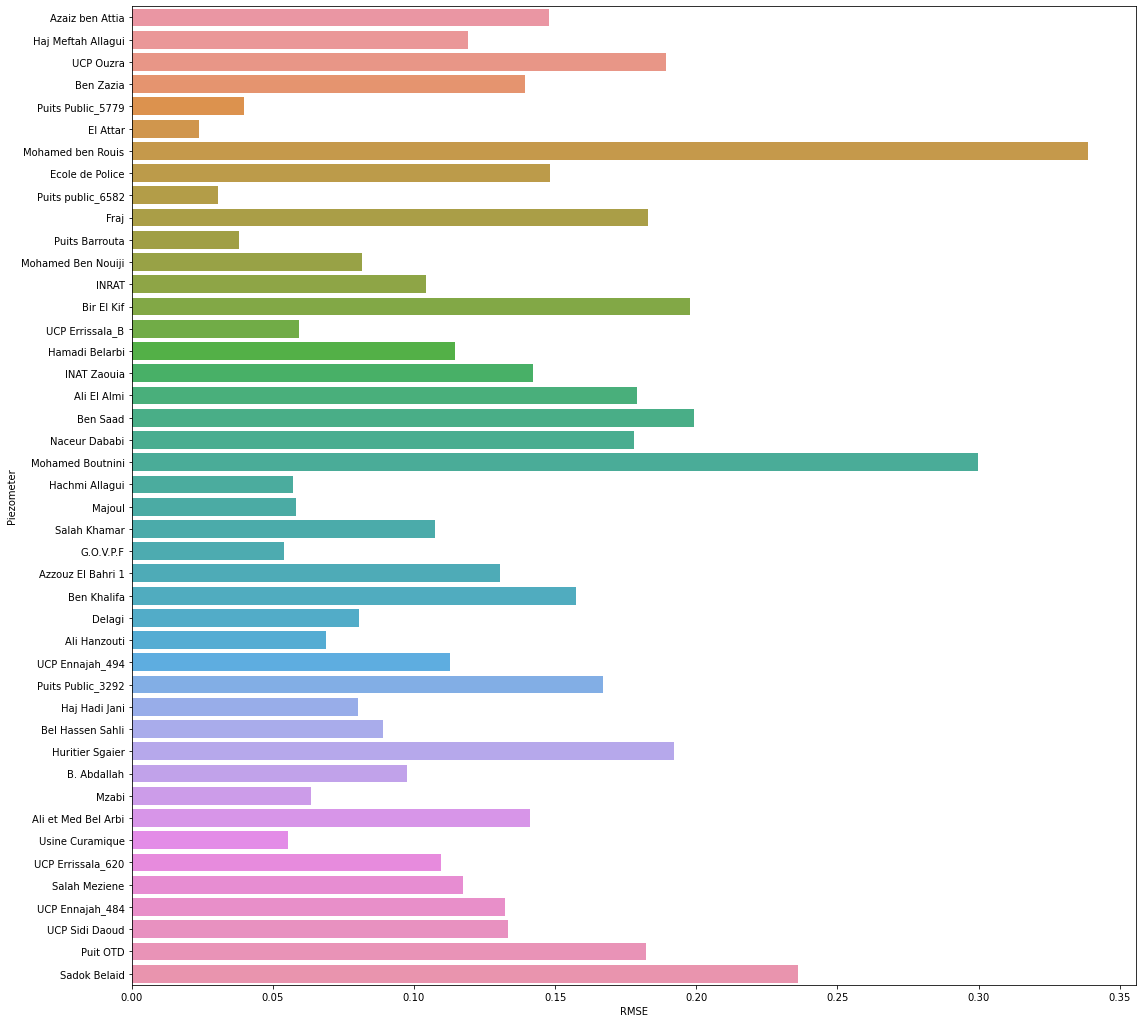

In [12]:
plt.figure(figsize=(18,18))

sns.barplot(x = 'RMSE',
            y = 'Piezometer',
            data = rmseDataXGB)
# Show the plot
plt.show()

In [13]:
errors = TestXGB[['Piezometer','Actual','Predicted']].copy()
errors.sample(n=10)

Piezometer     Actual  Predicted
Time_RF                                            
2013-07-23          Ben Zazia   9.948692  10.051283
2015-09-07       Ali Hanzouti   8.356923   8.330977
2013-06-26             Delagi  28.060000  27.999229
2011-09-27               Fraj  12.000000  11.915195
2011-09-19      Haj Hadi Jani  23.620474  23.619518
2009-04-16          G.O.V.P.F  36.761905  36.736172
2012-05-04      Haj Hadi Jani  23.802304  23.729847
2010-12-06      Naceur Dababi  44.167762  44.139114
2010-09-15     UCP Sidi Daoud   9.267364   9.602098
2007-08-31  Puits Public_5779  -8.963952  -8.962362

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

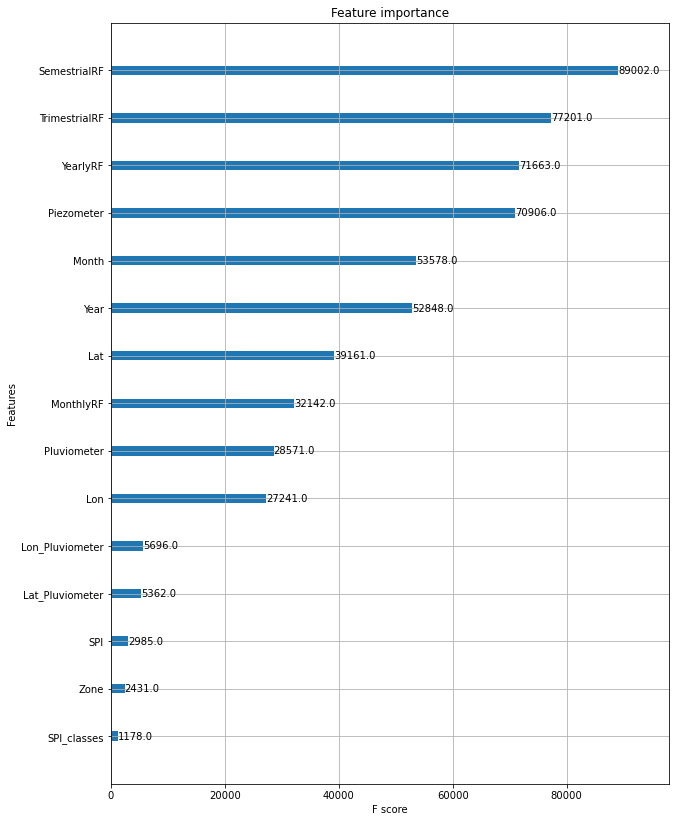

In [14]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model_xgb, (10,14))

Piezometer 0: Azaiz ben Attia : Root Mean Square Error (RMSE): 0.15


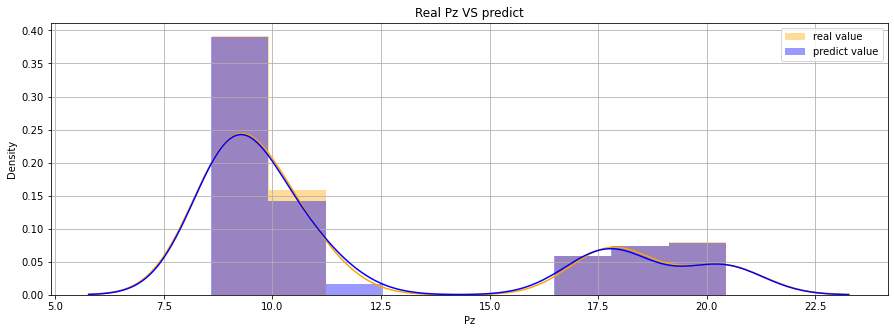

Piezometer 1: Haj Meftah Allagui : Root Mean Square Error (RMSE): 0.12


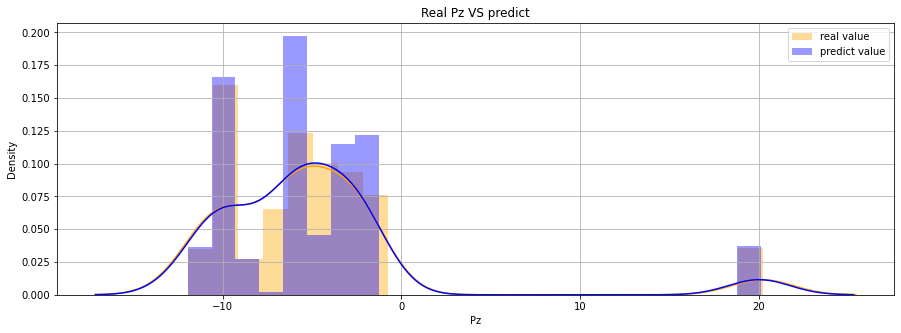

Piezometer 2: UCP Ouzra : Root Mean Square Error (RMSE): 0.19


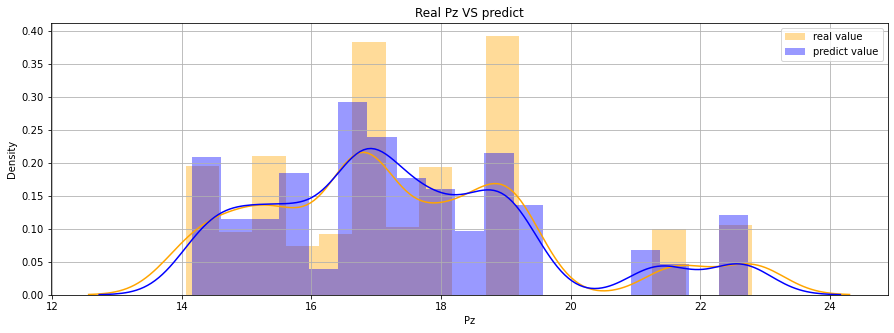

Piezometer 3: Ben Zazia : Root Mean Square Error (RMSE): 0.14


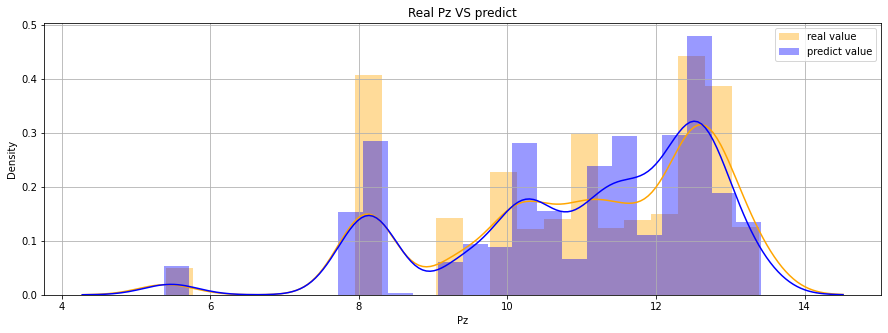

Piezometer 4: Puits Public_5779 : Root Mean Square Error (RMSE): 0.04


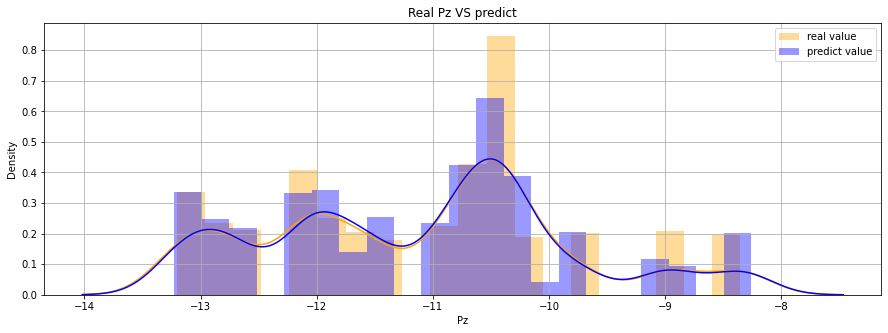

Piezometer 5: El Attar : Root Mean Square Error (RMSE): 0.02


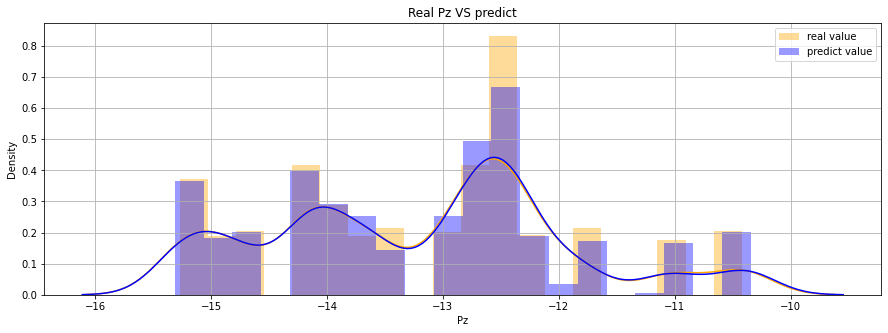

Piezometer 6: Mohamed ben Rouis : Root Mean Square Error (RMSE): 0.34


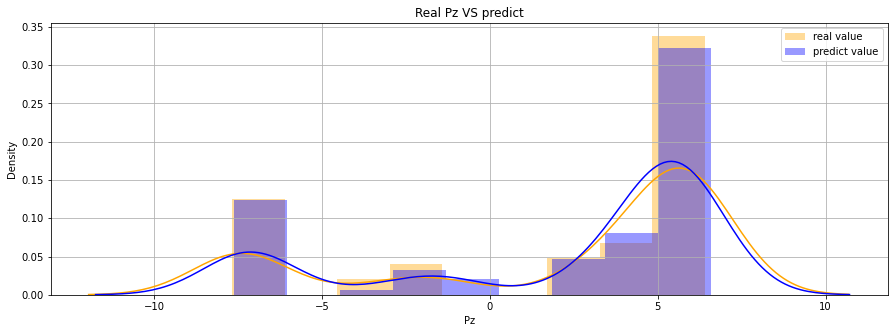

Piezometer 7: Ecole de Police : Root Mean Square Error (RMSE): 0.15


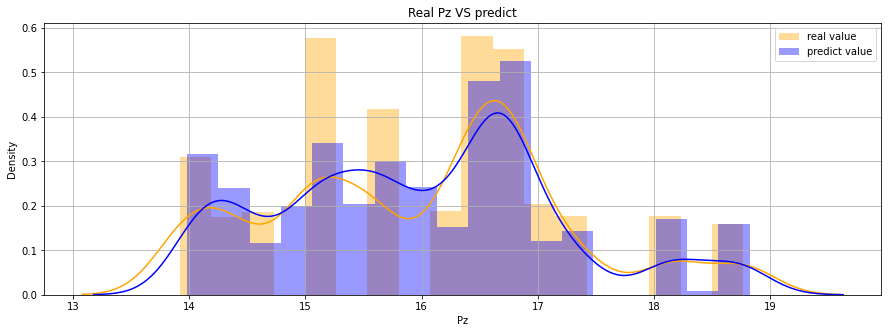

Piezometer 8: Puits public_6582 : Root Mean Square Error (RMSE): 0.03


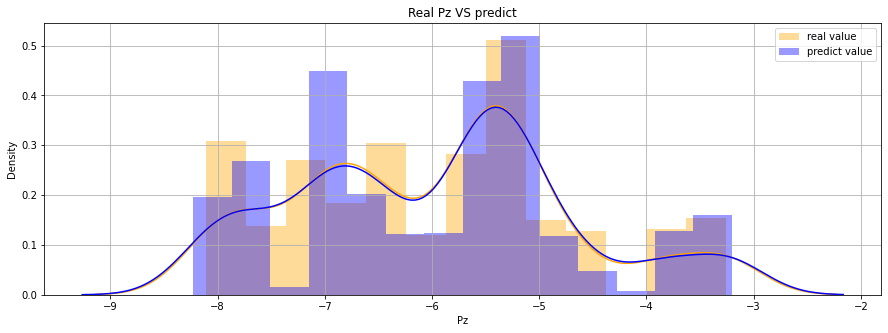

Piezometer 9: Fraj : Root Mean Square Error (RMSE): 0.18


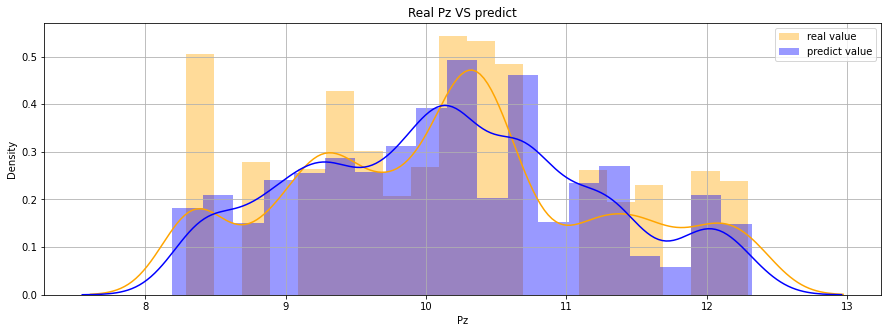

Piezometer 10: Puits Barrouta : Root Mean Square Error (RMSE): 0.04


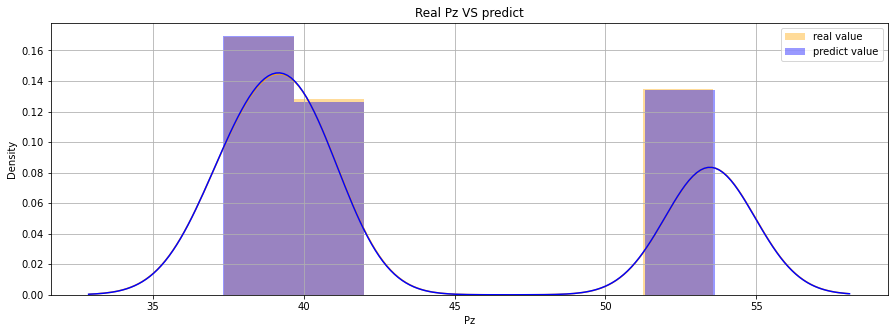

Piezometer 11: Mohamed Ben Nouiji : Root Mean Square Error (RMSE): 0.08


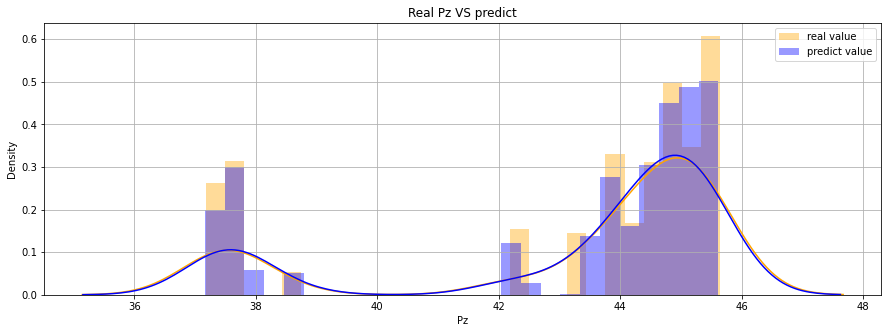

Piezometer 12: INRAT : Root Mean Square Error (RMSE): 0.1


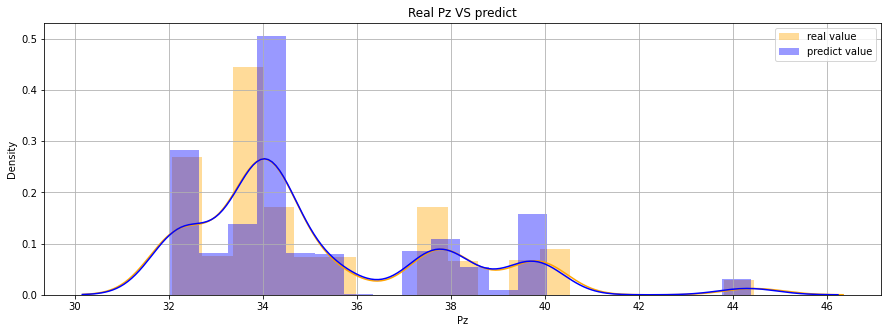

Piezometer 13: Bir El Kif : Root Mean Square Error (RMSE): 0.2


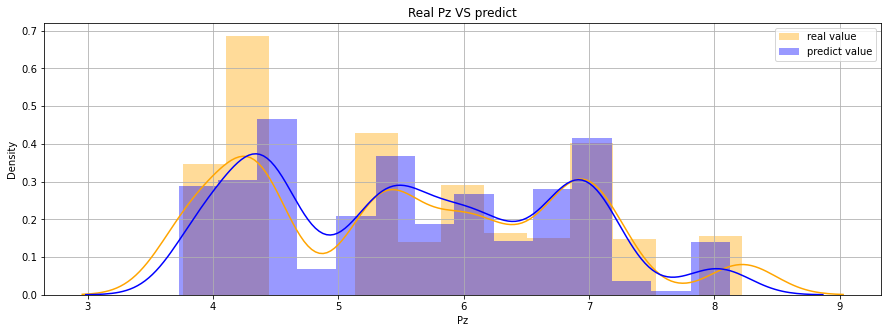

Piezometer 14: UCP Errissala_B : Root Mean Square Error (RMSE): 0.06


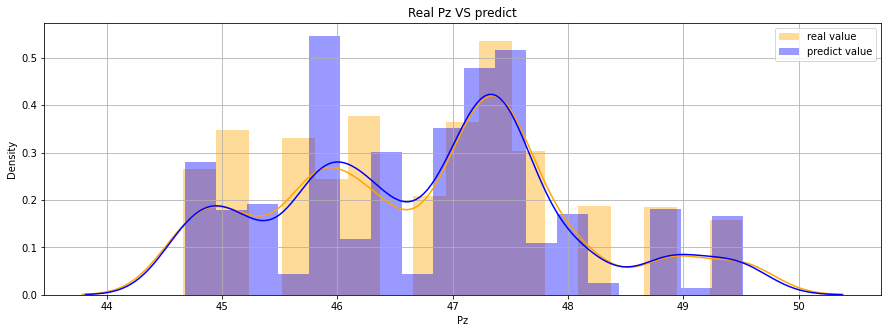

Piezometer 15: Hamadi Belarbi : Root Mean Square Error (RMSE): 0.11


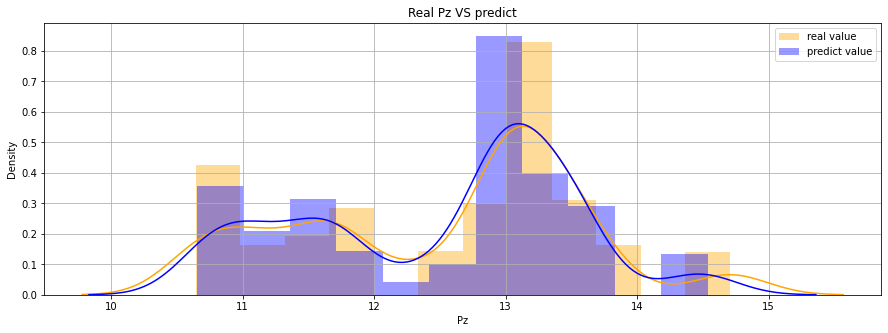

Piezometer 16: INAT Zaouia : Root Mean Square Error (RMSE): 0.14


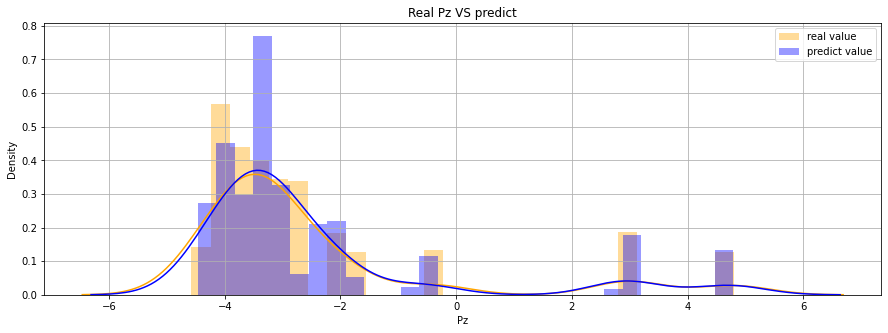

Piezometer 17: Ali El Almi : Root Mean Square Error (RMSE): 0.18


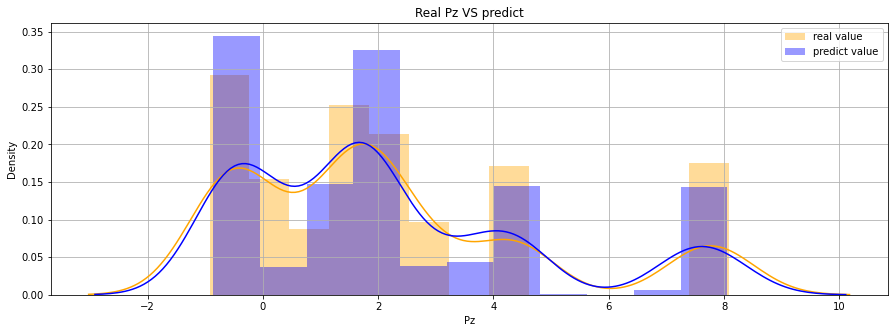

Piezometer 18: Ben Saad : Root Mean Square Error (RMSE): 0.2


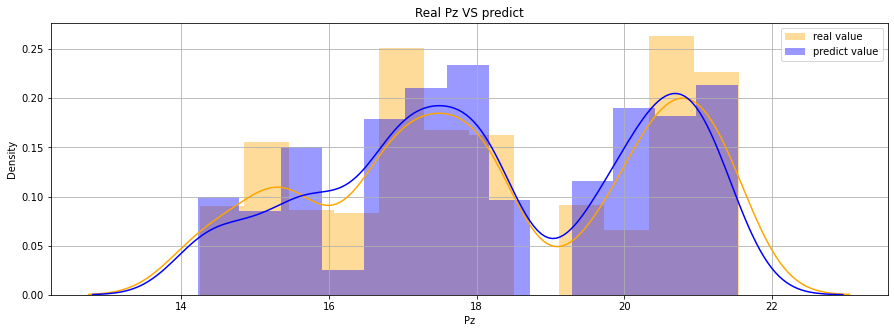

Piezometer 19: Naceur Dababi : Root Mean Square Error (RMSE): 0.18


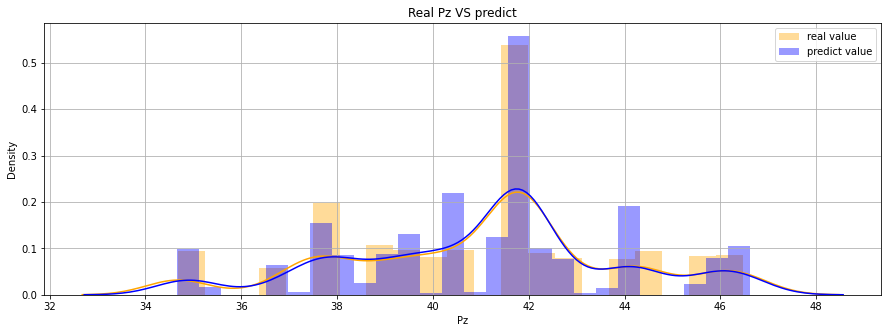

Piezometer 20: Mohamed Boutnini : Root Mean Square Error (RMSE): 0.3


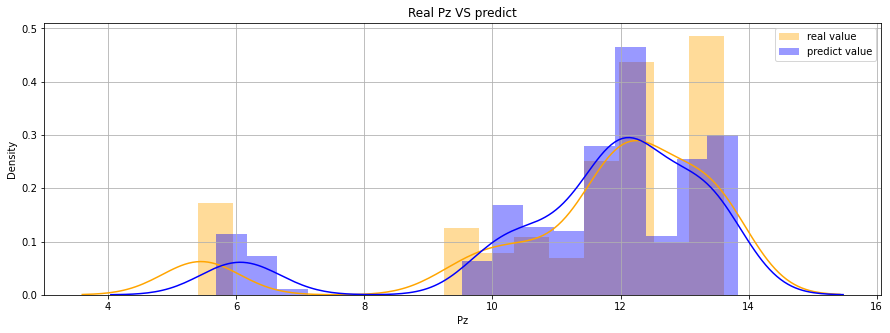

Piezometer 21: Hachmi Allagui : Root Mean Square Error (RMSE): 0.06


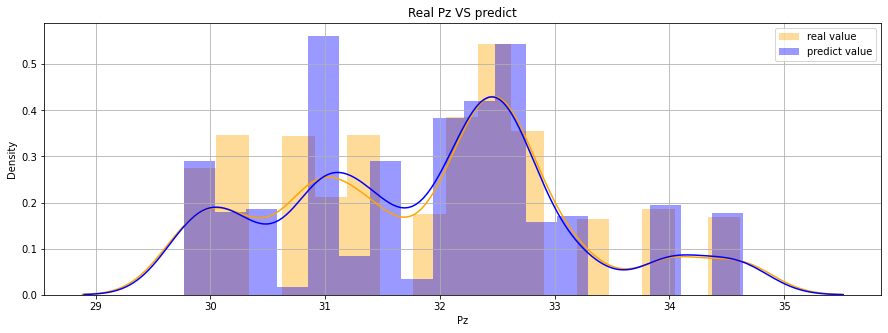

Piezometer 22: Majoul : Root Mean Square Error (RMSE): 0.06


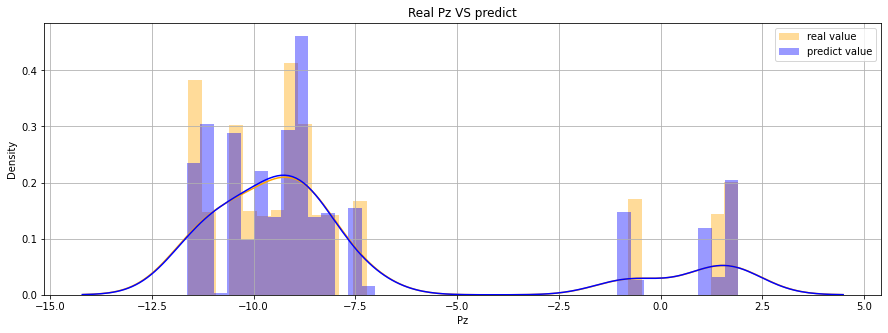

Piezometer 23: Salah Khamar : Root Mean Square Error (RMSE): 0.11


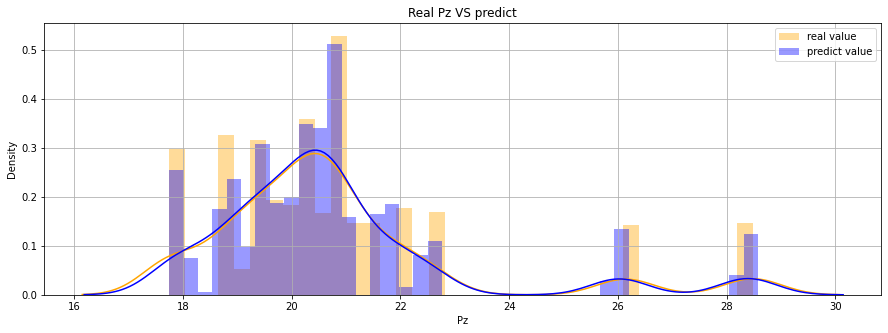

Piezometer 24: G.O.V.P.F : Root Mean Square Error (RMSE): 0.05


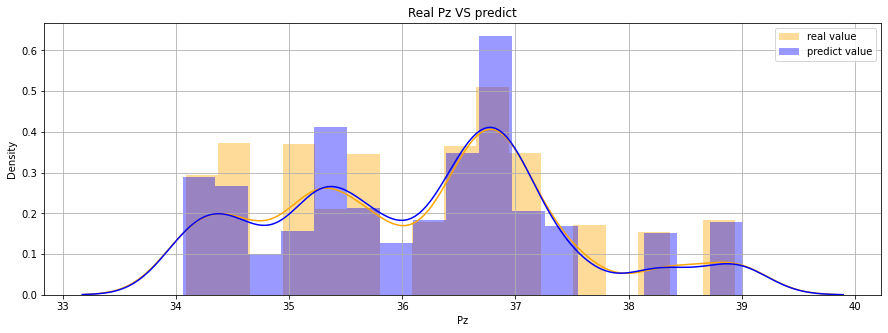

Piezometer 25: Azzouz El Bahri 1 : Root Mean Square Error (RMSE): 0.13


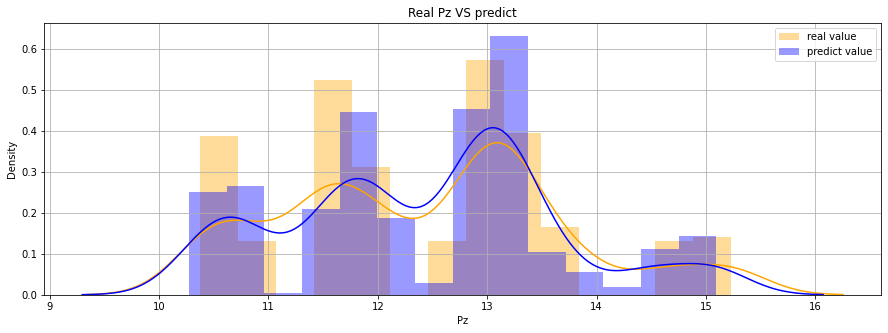

Piezometer 26: Ben Khalifa : Root Mean Square Error (RMSE): 0.16


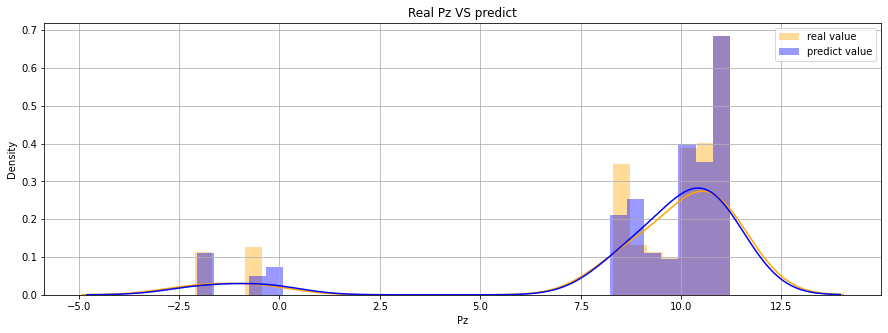

Piezometer 27: Delagi : Root Mean Square Error (RMSE): 0.08


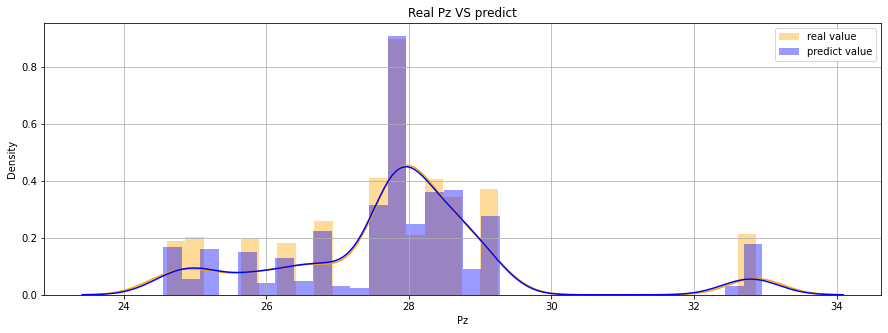

Piezometer 28: Ali Hanzouti : Root Mean Square Error (RMSE): 0.07


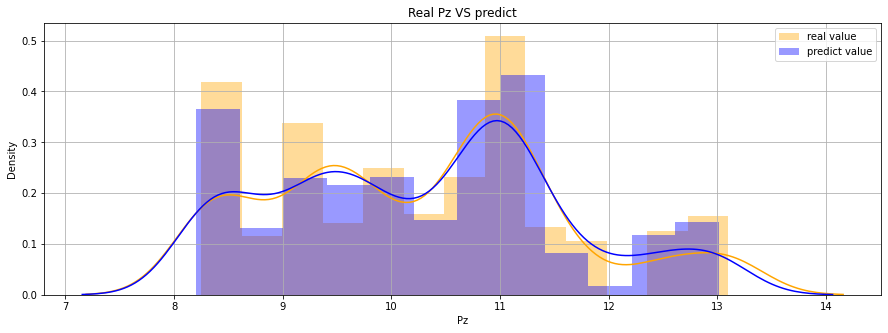

Piezometer 29: UCP Ennajah_494 : Root Mean Square Error (RMSE): 0.11


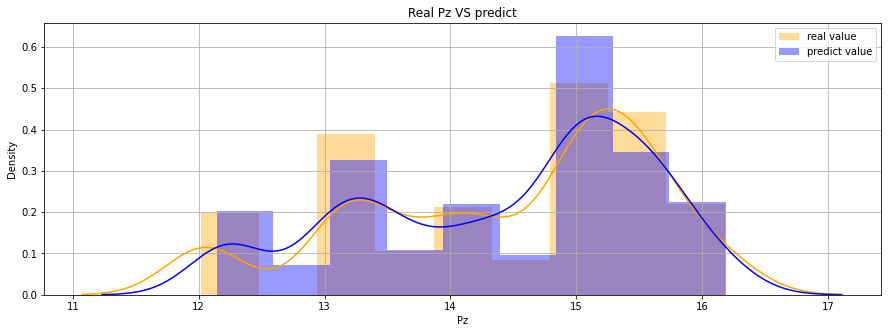

Piezometer 30: Puits Public_3292 : Root Mean Square Error (RMSE): 0.17


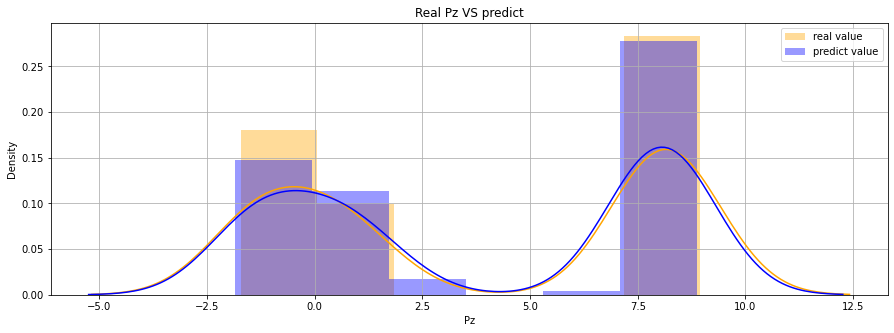

Piezometer 31: Haj Hadi Jani : Root Mean Square Error (RMSE): 0.08


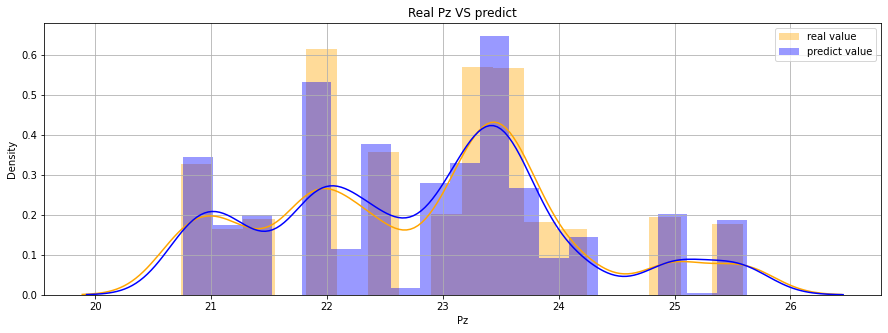

Piezometer 32: Bel Hassen Sahli : Root Mean Square Error (RMSE): 0.09


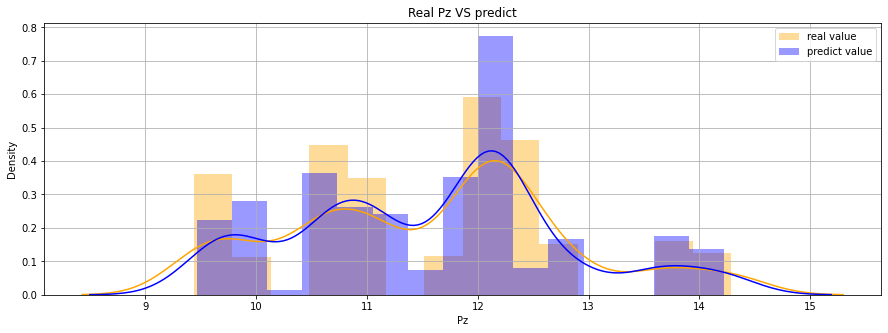

Piezometer 33: Huritier Sgaier : Root Mean Square Error (RMSE): 0.19


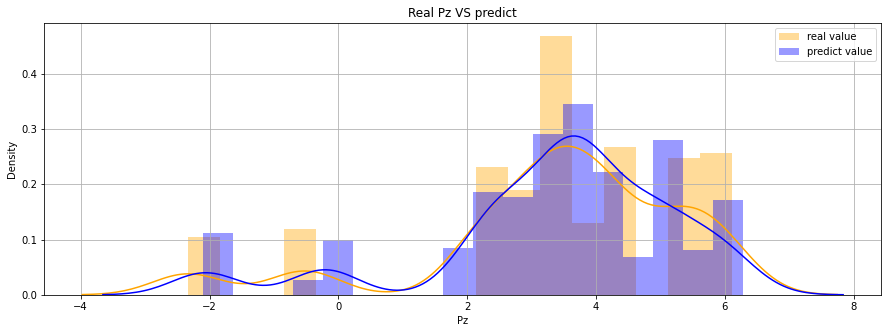

Piezometer 34: B. Abdallah : Root Mean Square Error (RMSE): 0.1


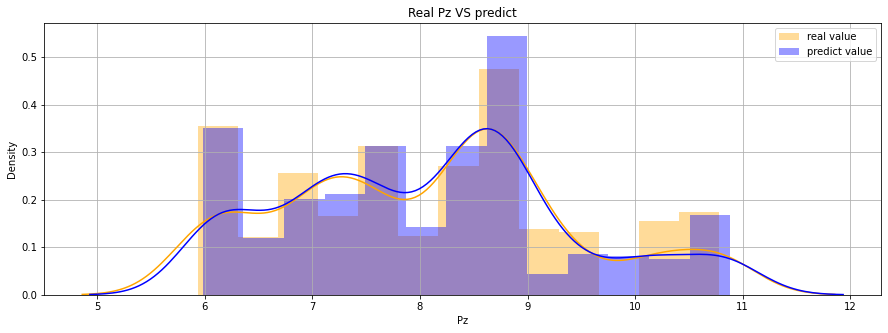

Piezometer 35: Mzabi : Root Mean Square Error (RMSE): 0.06


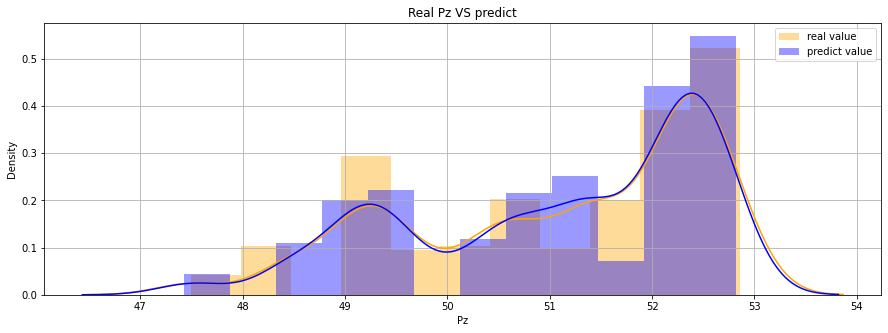

Piezometer 36: Ali et Med Bel Arbi : Root Mean Square Error (RMSE): 0.14


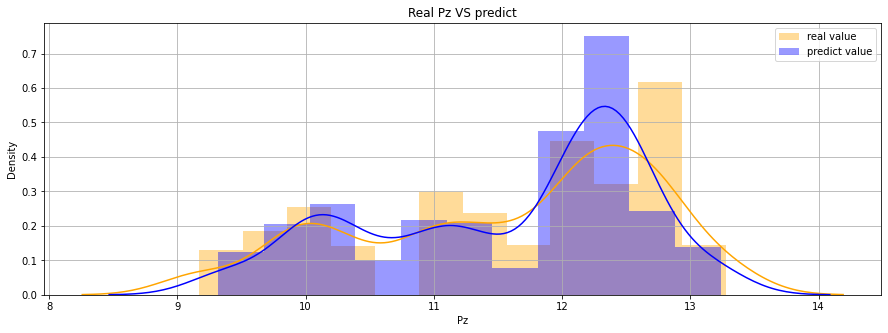

Piezometer 37: Usine Curamique : Root Mean Square Error (RMSE): 0.06


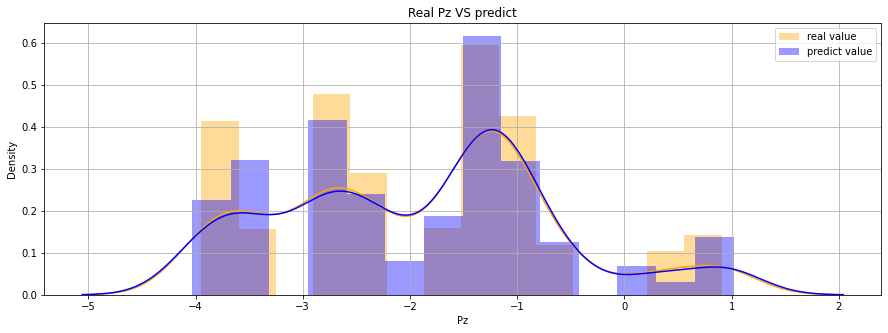

Piezometer 38: UCP Errissala_620 : Root Mean Square Error (RMSE): 0.11


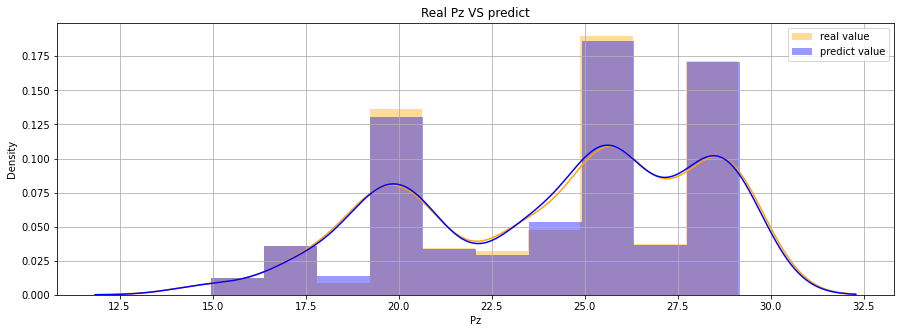

Piezometer 39: Salah Meziene : Root Mean Square Error (RMSE): 0.12


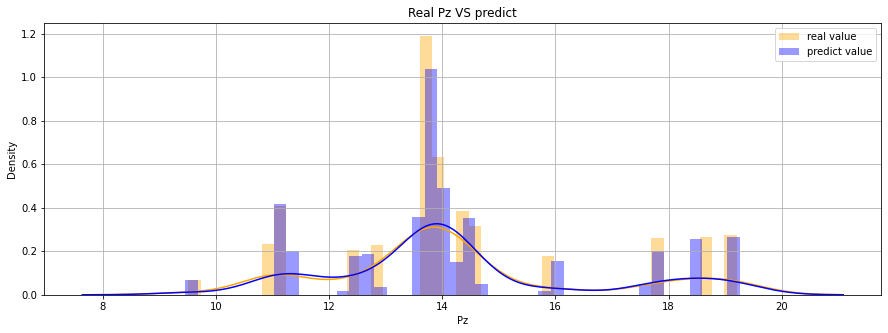

Piezometer 40: UCP Ennajah_484 : Root Mean Square Error (RMSE): 0.13


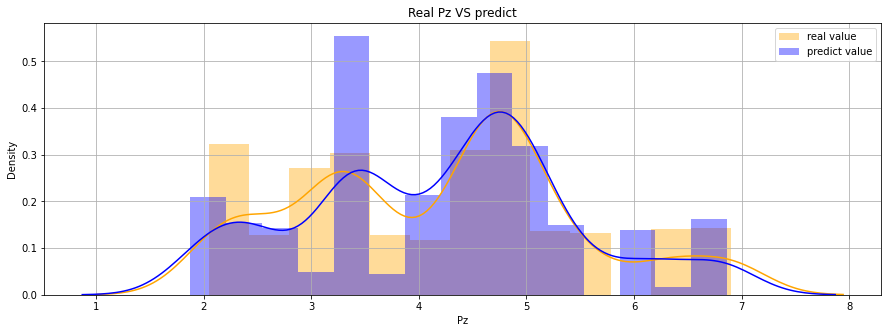

Piezometer 41: UCP Sidi Daoud : Root Mean Square Error (RMSE): 0.13


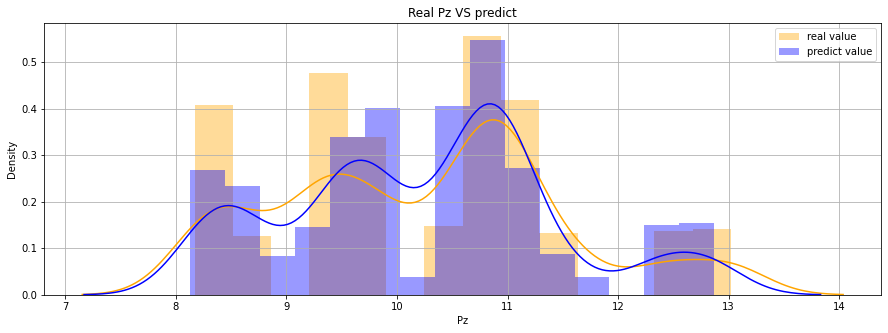

Piezometer 42: Puit OTD : Root Mean Square Error (RMSE): 0.18


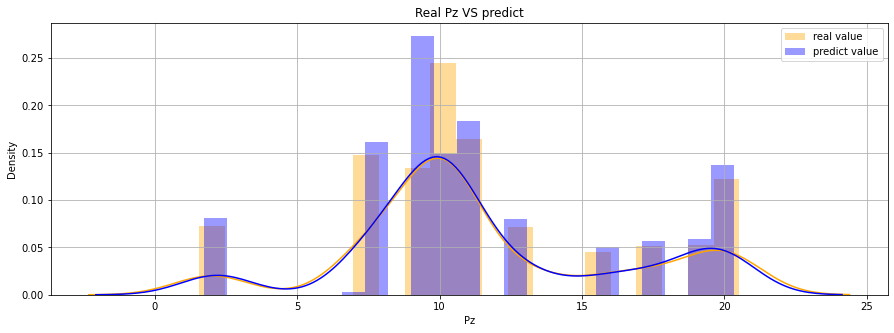

Piezometer 43: Sadok Belaid : Root Mean Square Error (RMSE): 0.24


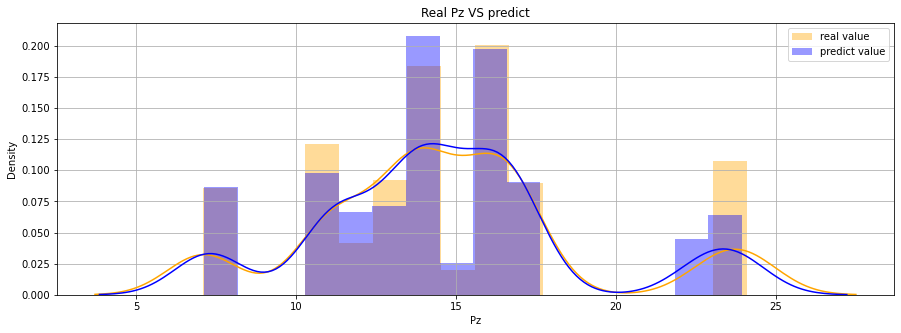

In [16]:
piezo=TestXGB['Piezometer'].unique()
for i in range(0,len(piezo)):
    RMSE=np.sqrt(mean_squared_error(TestXGB.Actual[TestXGB.Piezometer==piezo[i]],TestXGB.Predicted[TestXGB.Piezometer==piezo[i]]))
    print(f'Piezometer '+ str(i) + ': '+piezo[i]+f' : Root Mean Square Error (RMSE): {np.round(RMSE, 2)}')
    plt.figure(figsize=(15, 5))
    ax1 = sns.distplot(TestXGB.Actual[TestXGB.Piezometer==piezo[i]],color="orange", label="real value")
    ax2 = sns.distplot(TestXGB.Predicted[TestXGB.Piezometer==piezo[i]],  color="blue", label="predict value", ax=ax1)
    plt.title("Real Pz VS predict")
    plt.xlabel("Pz")
    plt.gca().legend()
    plt.grid()
    plt.show()


Piezometer 0: Azaiz ben Attia : Root Mean Square Error (RMSE): 0.15


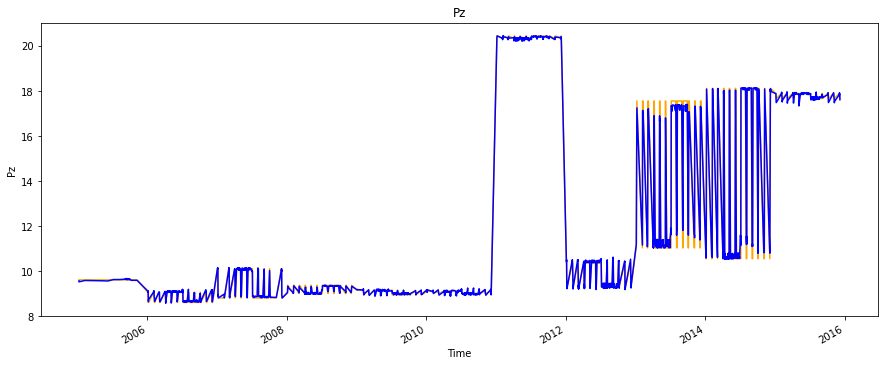

Piezometer 1: Haj Meftah Allagui : Root Mean Square Error (RMSE): 0.12


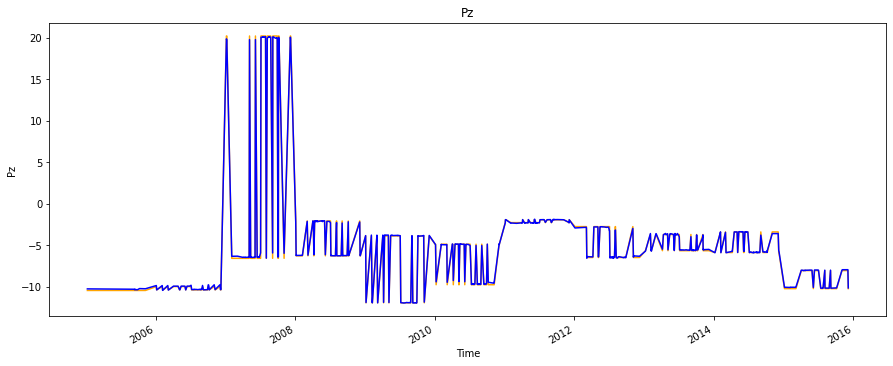

Piezometer 2: UCP Ouzra : Root Mean Square Error (RMSE): 0.19


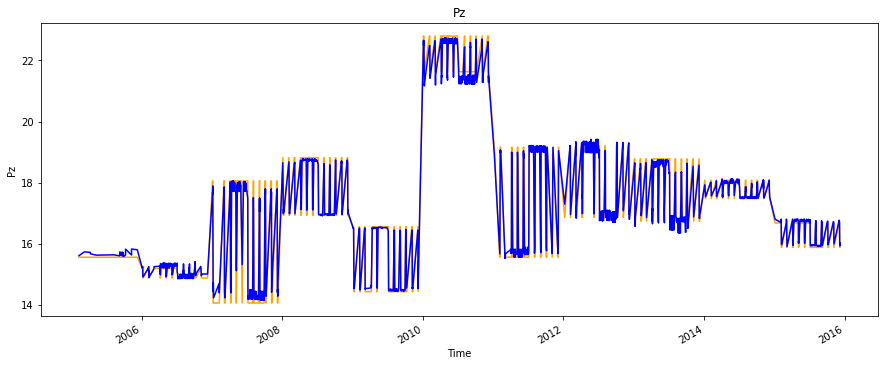

Piezometer 3: Ben Zazia : Root Mean Square Error (RMSE): 0.14


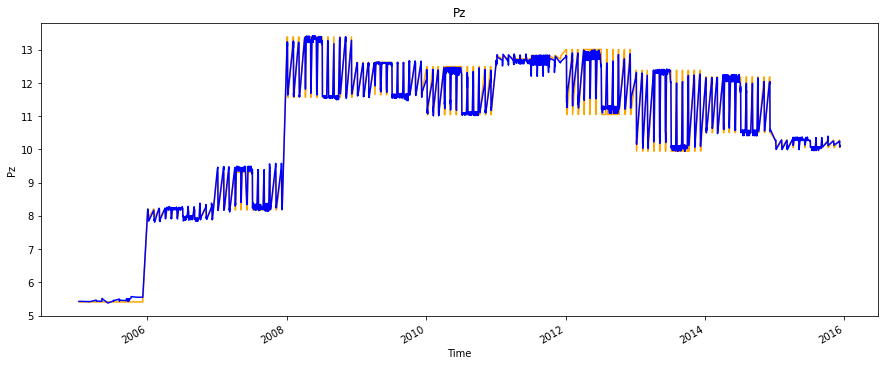

Piezometer 4: Puits Public_5779 : Root Mean Square Error (RMSE): 0.04


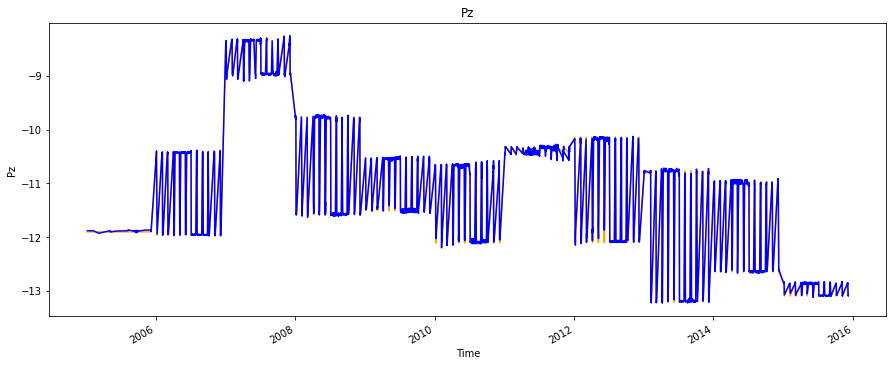

Piezometer 5: El Attar : Root Mean Square Error (RMSE): 0.02


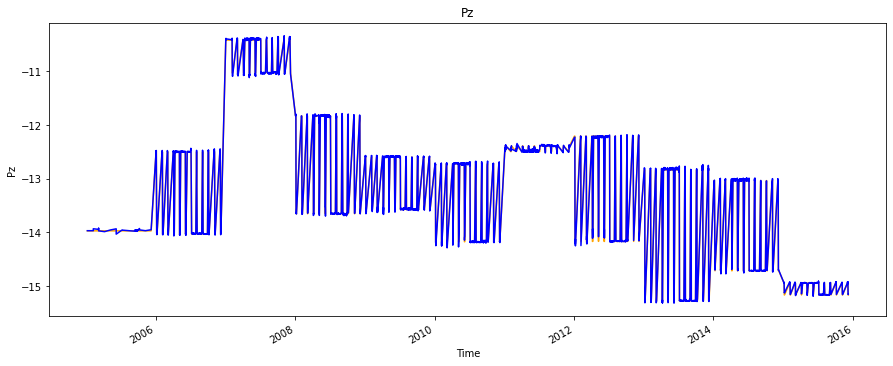

Piezometer 6: Mohamed ben Rouis : Root Mean Square Error (RMSE): 0.34


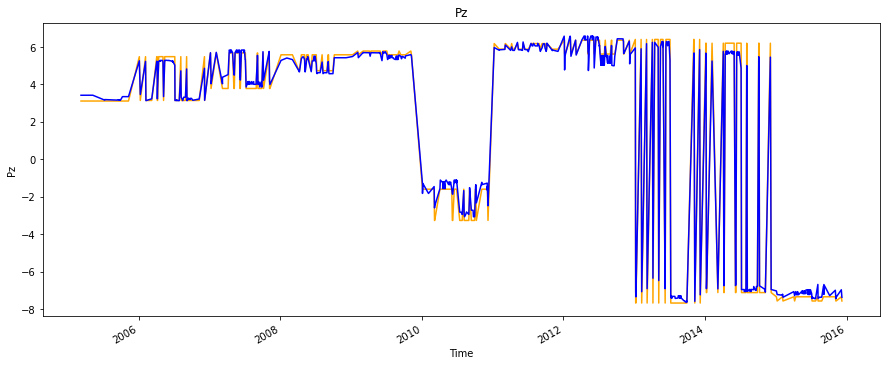

Piezometer 7: Ecole de Police : Root Mean Square Error (RMSE): 0.15


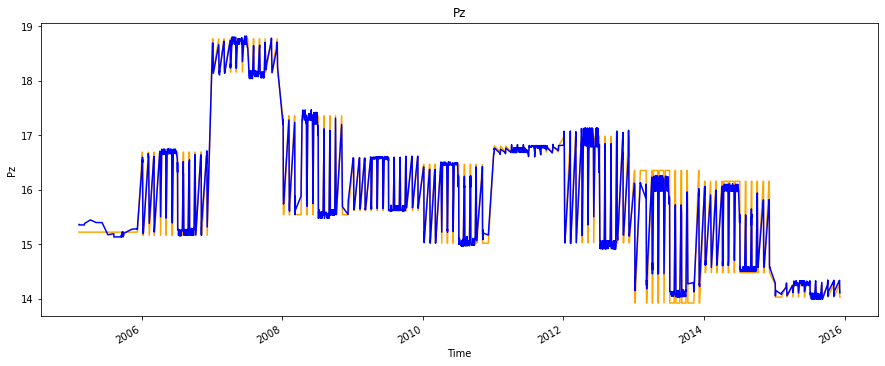

Piezometer 8: Puits public_6582 : Root Mean Square Error (RMSE): 0.03


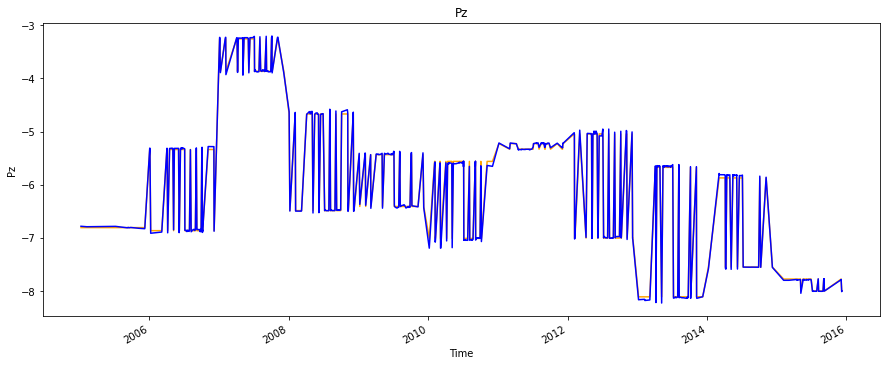

Piezometer 9: Fraj : Root Mean Square Error (RMSE): 0.18


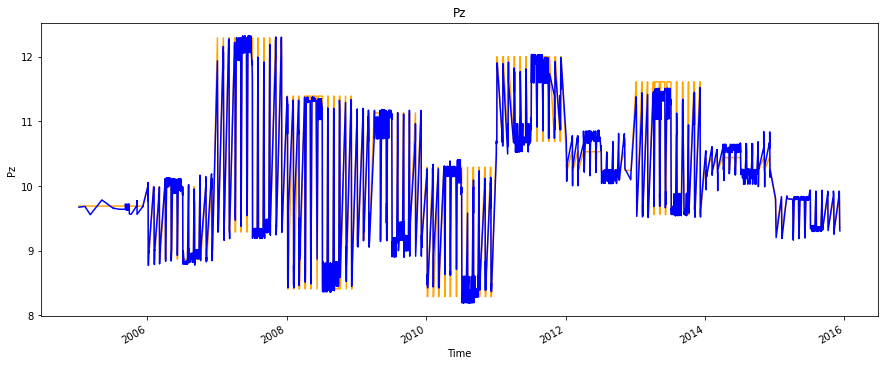

Piezometer 10: Puits Barrouta : Root Mean Square Error (RMSE): 0.04


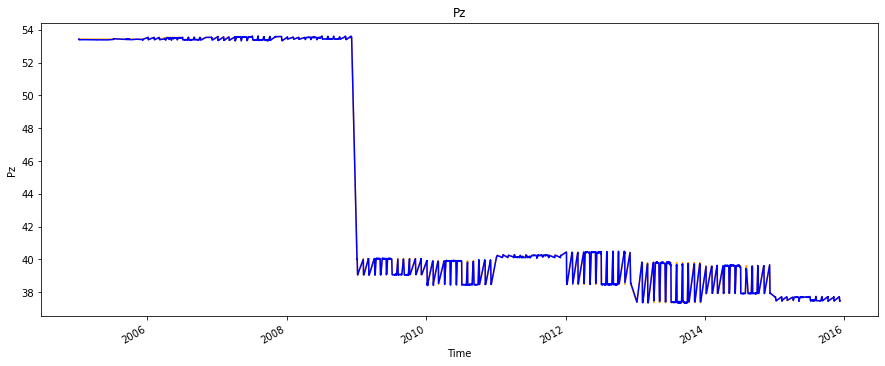

Piezometer 11: Mohamed Ben Nouiji : Root Mean Square Error (RMSE): 0.08


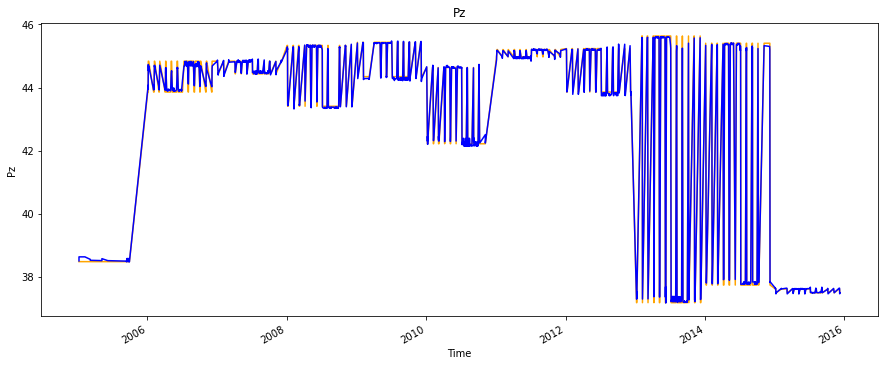

Piezometer 12: INRAT : Root Mean Square Error (RMSE): 0.1


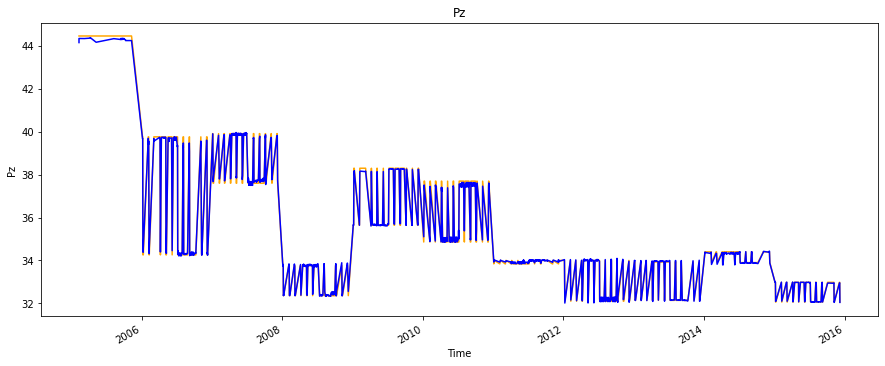

Piezometer 13: Bir El Kif : Root Mean Square Error (RMSE): 0.2


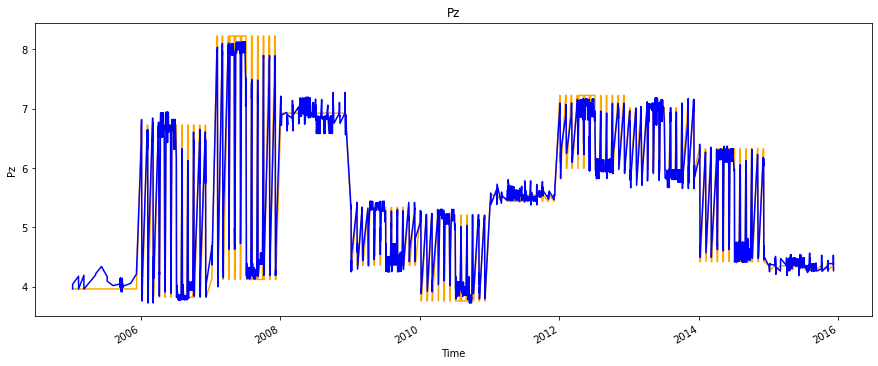

Piezometer 14: UCP Errissala_B : Root Mean Square Error (RMSE): 0.06


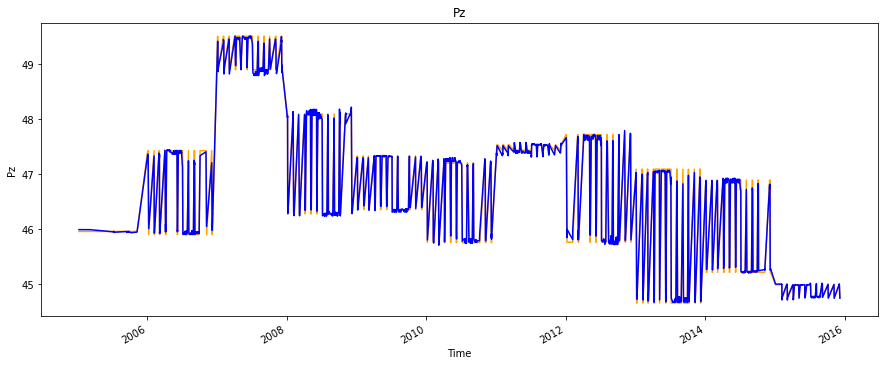

Piezometer 15: Hamadi Belarbi : Root Mean Square Error (RMSE): 0.11


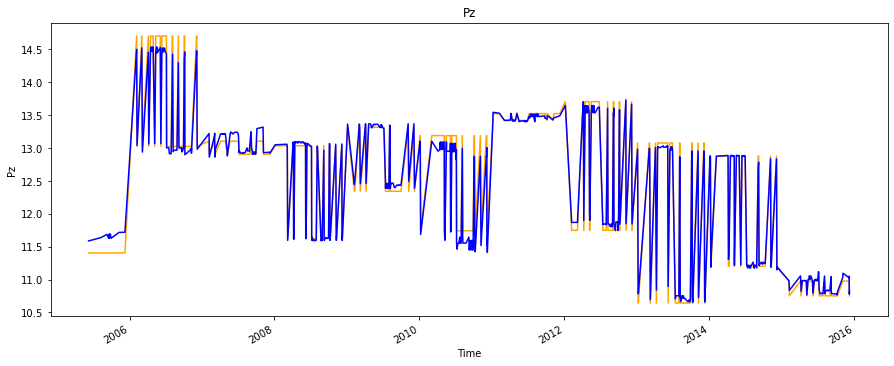

Piezometer 16: INAT Zaouia : Root Mean Square Error (RMSE): 0.14


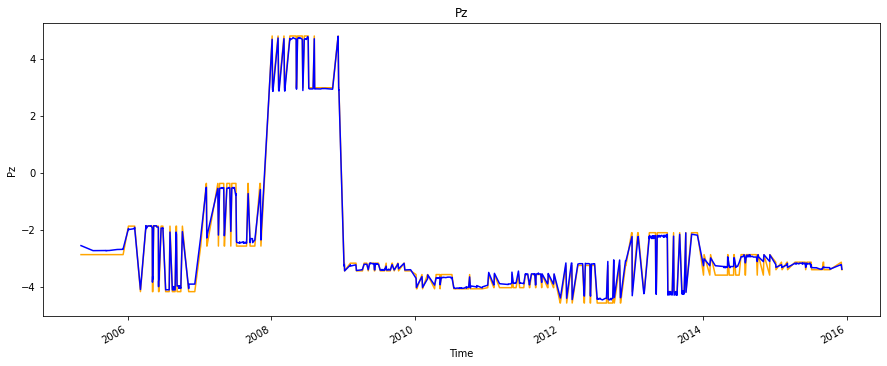

Piezometer 17: Ali El Almi : Root Mean Square Error (RMSE): 0.18


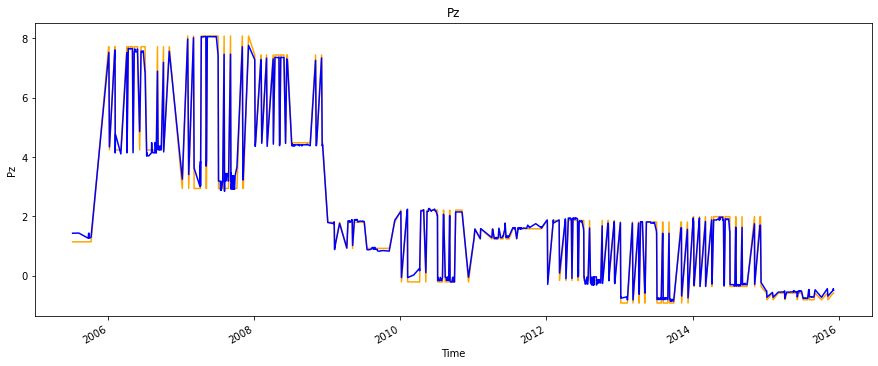

Piezometer 18: Ben Saad : Root Mean Square Error (RMSE): 0.2


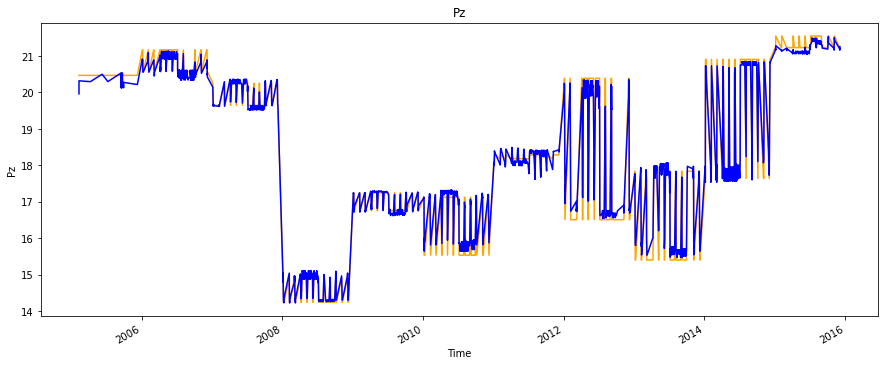

Piezometer 19: Naceur Dababi : Root Mean Square Error (RMSE): 0.18


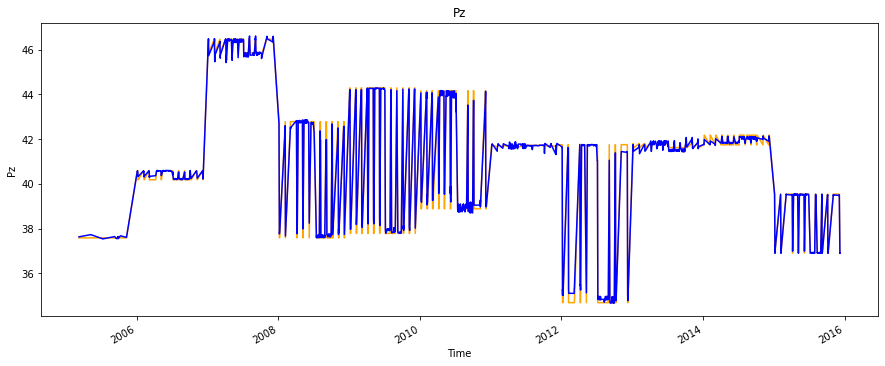

Piezometer 20: Mohamed Boutnini : Root Mean Square Error (RMSE): 0.3


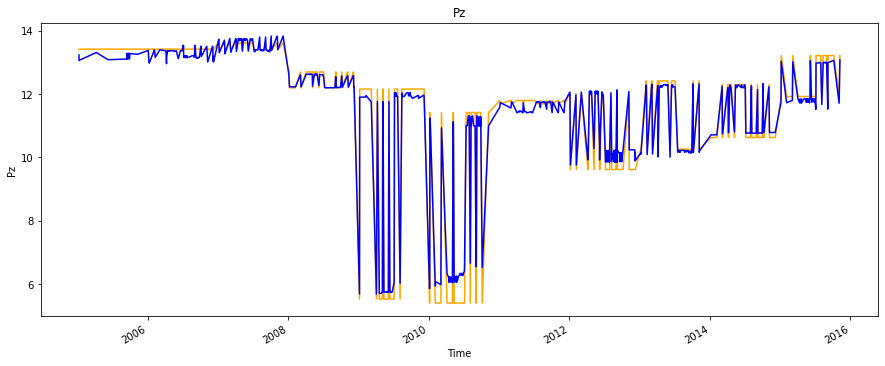

Piezometer 21: Hachmi Allagui : Root Mean Square Error (RMSE): 0.06


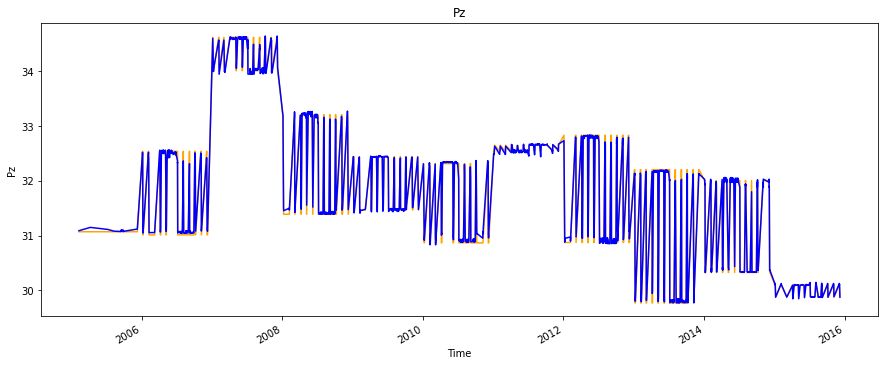

Piezometer 22: Majoul : Root Mean Square Error (RMSE): 0.06


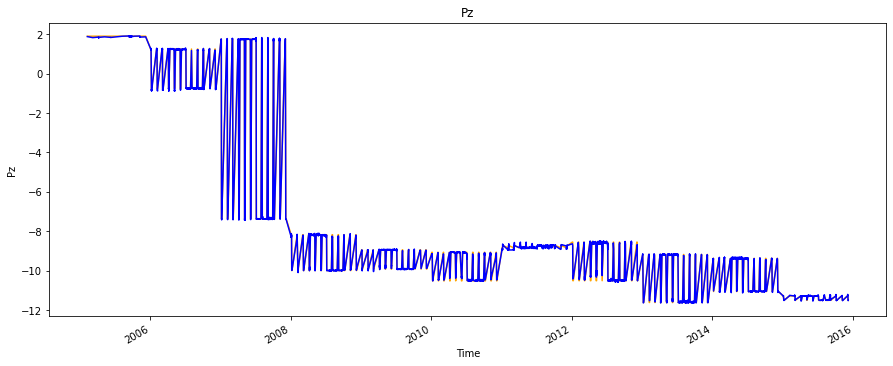

Piezometer 23: Salah Khamar : Root Mean Square Error (RMSE): 0.11


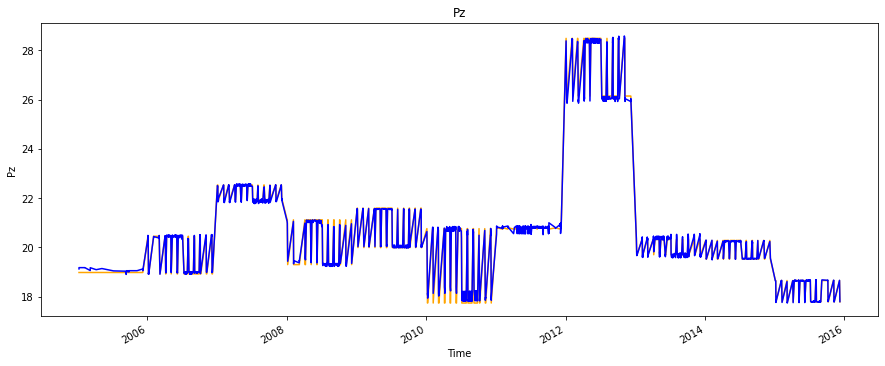

Piezometer 24: G.O.V.P.F : Root Mean Square Error (RMSE): 0.05


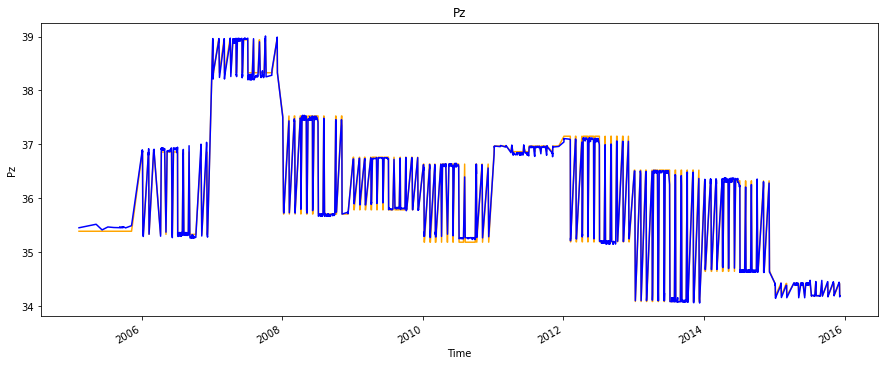

Piezometer 25: Azzouz El Bahri 1 : Root Mean Square Error (RMSE): 0.13


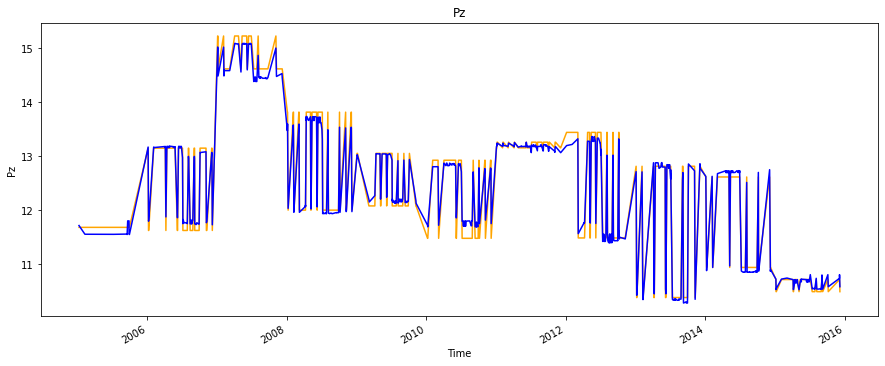

Piezometer 26: Ben Khalifa : Root Mean Square Error (RMSE): 0.16


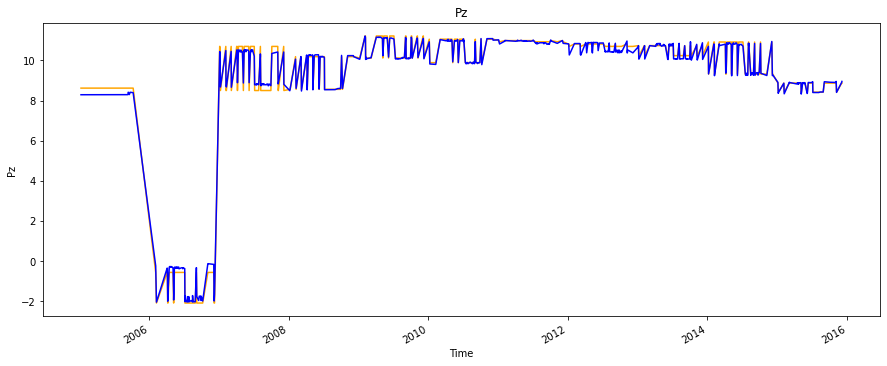

Piezometer 27: Delagi : Root Mean Square Error (RMSE): 0.08


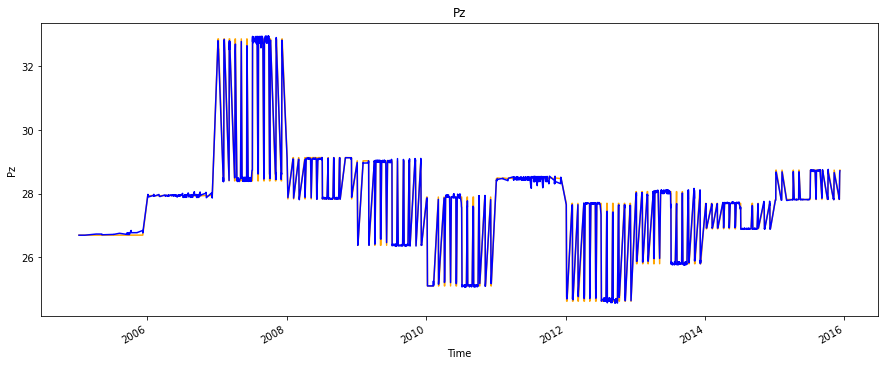

Piezometer 28: Ali Hanzouti : Root Mean Square Error (RMSE): 0.07


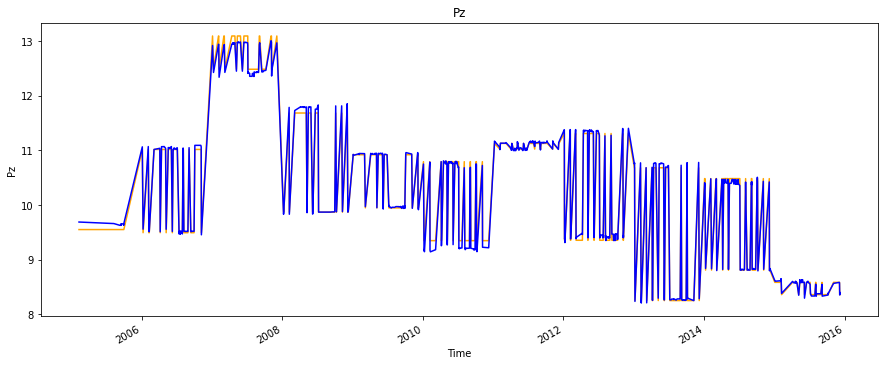

Piezometer 29: UCP Ennajah_494 : Root Mean Square Error (RMSE): 0.11


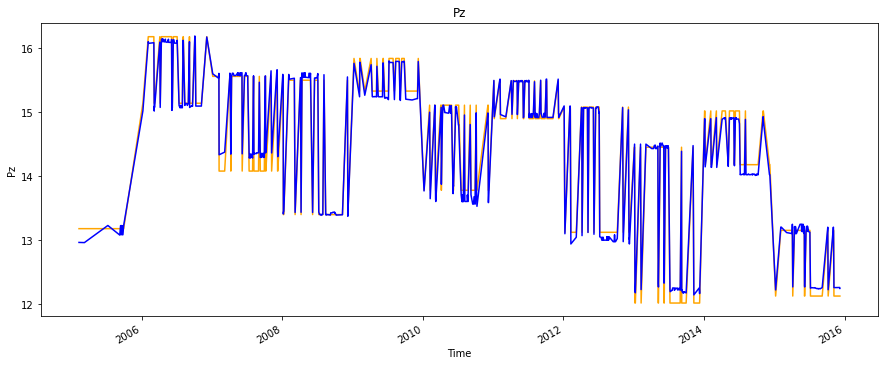

Piezometer 30: Puits Public_3292 : Root Mean Square Error (RMSE): 0.17


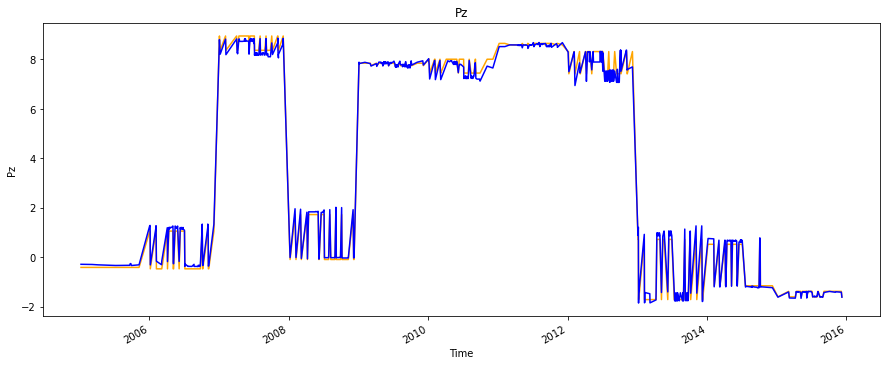

Piezometer 31: Haj Hadi Jani : Root Mean Square Error (RMSE): 0.08


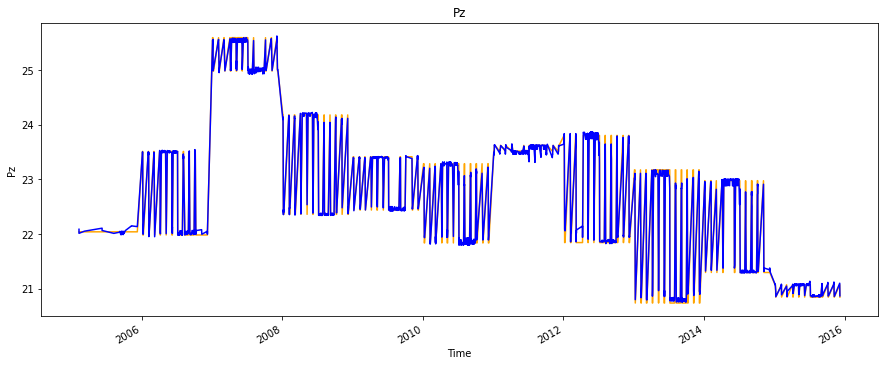

Piezometer 32: Bel Hassen Sahli : Root Mean Square Error (RMSE): 0.09


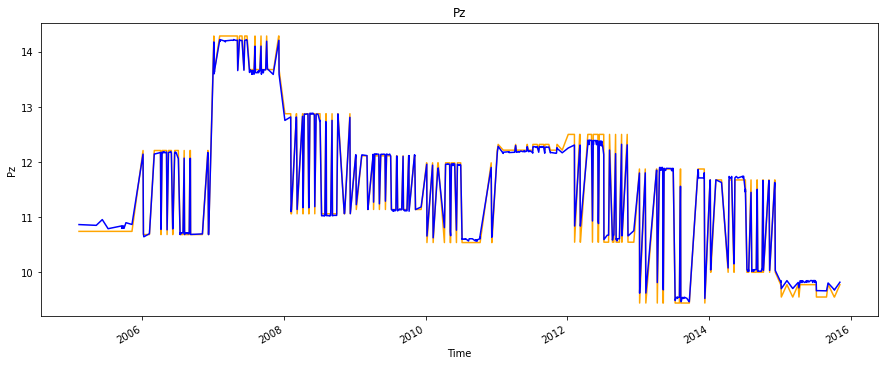

Piezometer 33: Huritier Sgaier : Root Mean Square Error (RMSE): 0.19


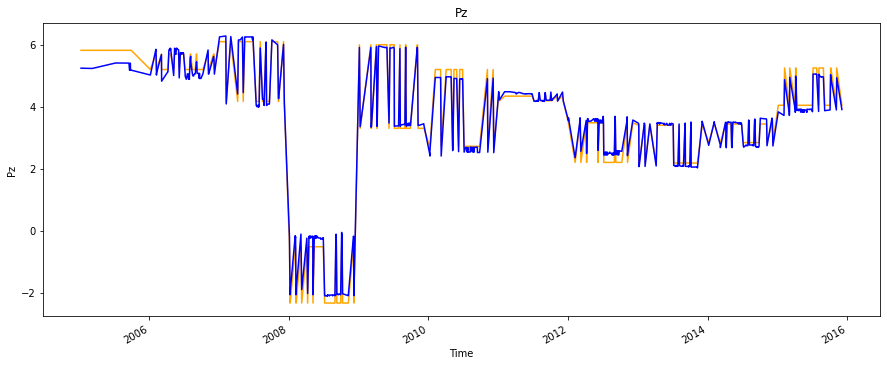

Piezometer 34: B. Abdallah : Root Mean Square Error (RMSE): 0.1


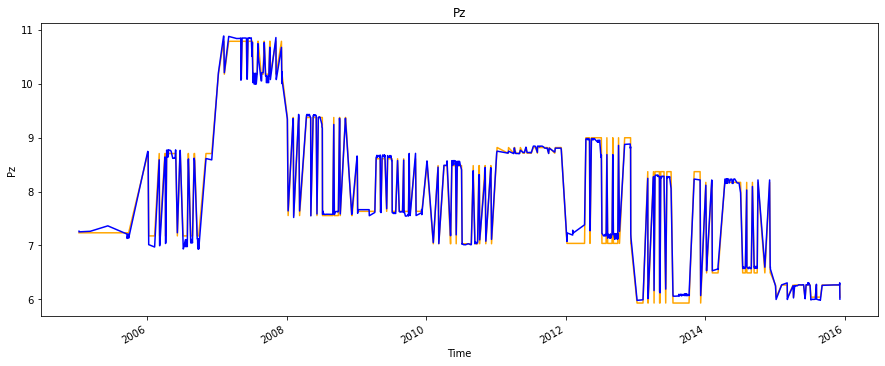

Piezometer 35: Mzabi : Root Mean Square Error (RMSE): 0.06


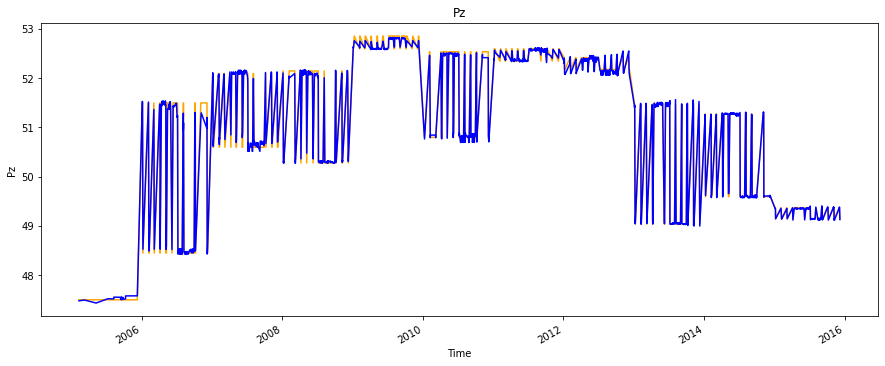

Piezometer 36: Ali et Med Bel Arbi : Root Mean Square Error (RMSE): 0.14


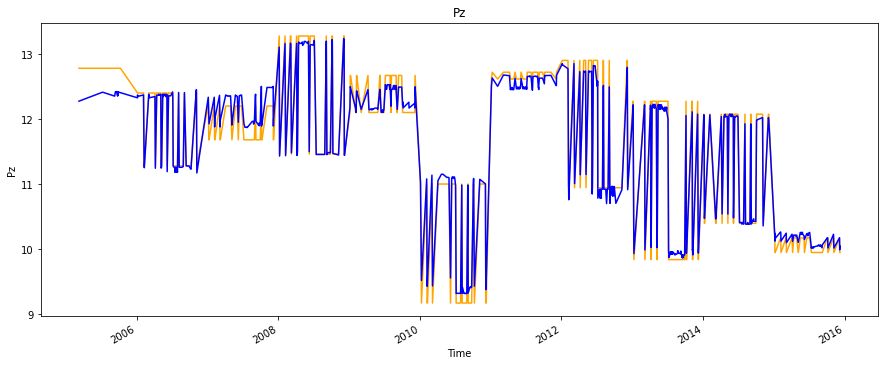

Piezometer 37: Usine Curamique : Root Mean Square Error (RMSE): 0.06


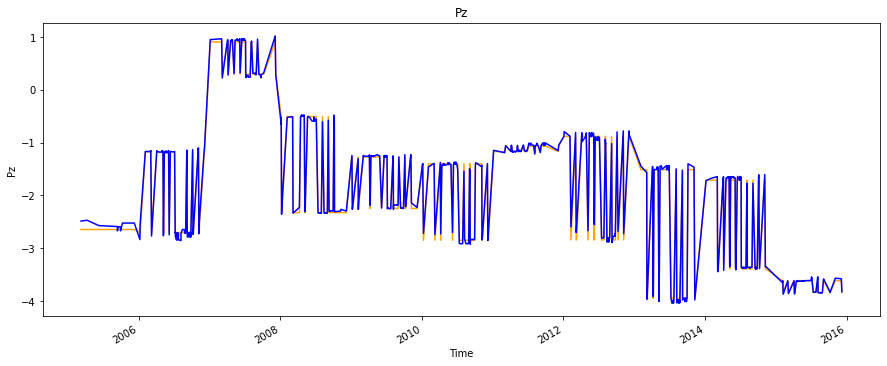

Piezometer 38: UCP Errissala_620 : Root Mean Square Error (RMSE): 0.11


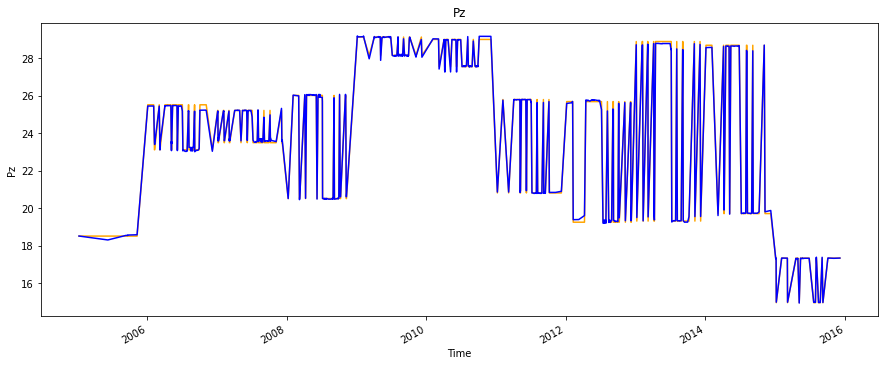

Piezometer 39: Salah Meziene : Root Mean Square Error (RMSE): 0.12


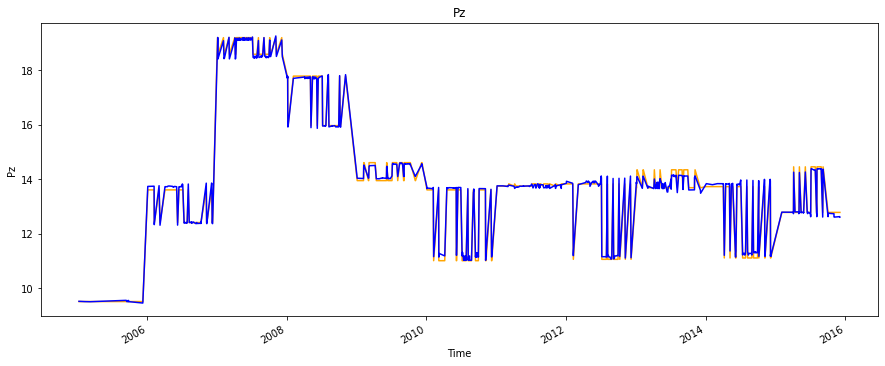

Piezometer 40: UCP Ennajah_484 : Root Mean Square Error (RMSE): 0.13


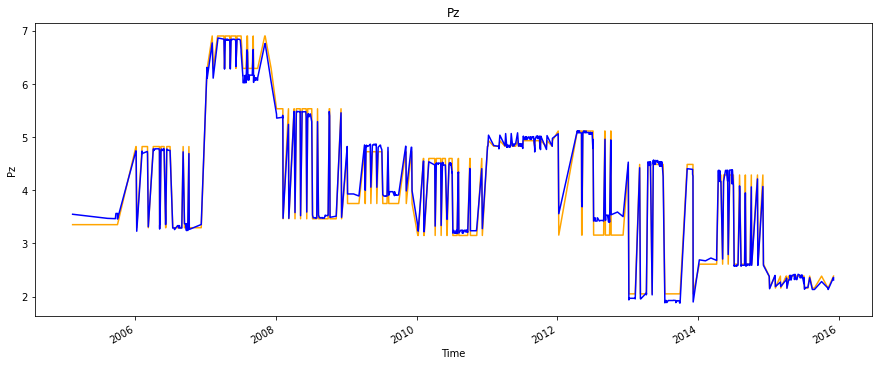

Piezometer 41: UCP Sidi Daoud : Root Mean Square Error (RMSE): 0.13


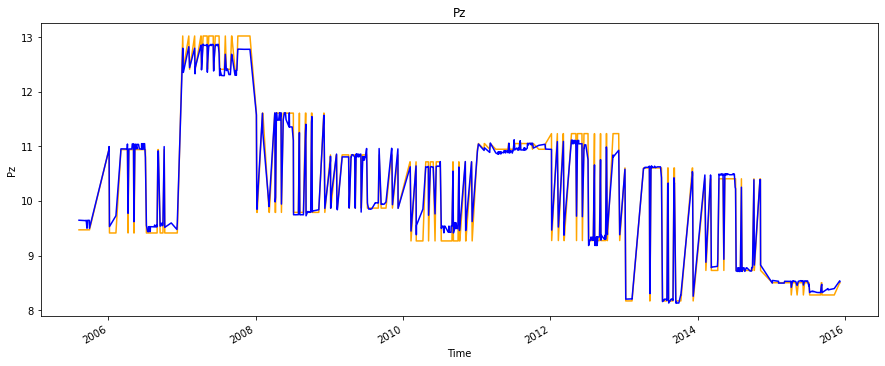

Piezometer 42: Puit OTD : Root Mean Square Error (RMSE): 0.18


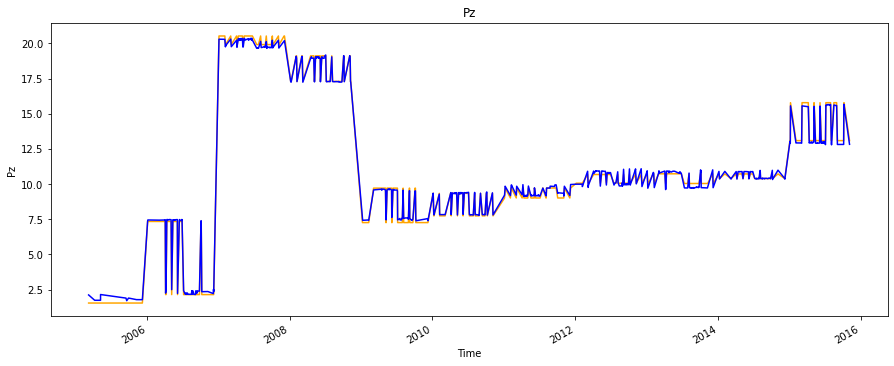

Piezometer 43: Sadok Belaid : Root Mean Square Error (RMSE): 0.24


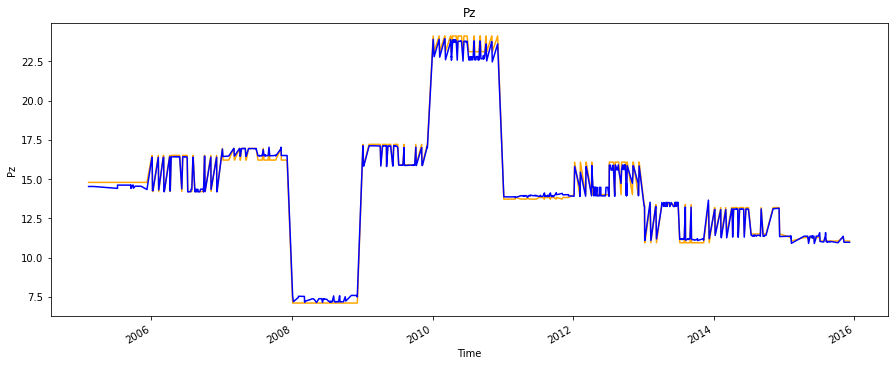

In [15]:
piezo=TestXGB['Piezometer'].unique()
for i in range(0,len(piezo)):
    RMSE=np.sqrt(mean_squared_error(TestXGB.Actual[TestXGB.Piezometer==piezo[i]],TestXGB.Predicted[TestXGB.Piezometer==piezo[i]]))
    print(f'Piezometer '+ str(i) + ': '+piezo[i]+f' : Root Mean Square Error (RMSE): {np.round(RMSE, 2)}')
    TestXGB['Actual'][TestXGB.Piezometer==piezo[i]].plot(figsize=(15, 6),color='orange')
    TestXGB['Predicted'][TestXGB.Piezometer==piezo[i]].plot(figsize=(15, 6),color='blue')

    plt.xlabel("Time")
    plt.ylabel('Pz')
    plt.title(f"{str('Pz')}")
    plt.show()